# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados do Experimento Univariado para a Previsão de 2022 

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Análise Univariada da Série de Arrecadação do ICMS Paulista 

In [369]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
from pmdarima.arima import auto_arima, nsdiffs, ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(10,7)})

In [370]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [371]:
df_main_orig = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])
df_main_orig.head()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
0,2003-01-01,3.360296e+09,277.173,3.4384,96.15,22,277.173,3.4384,96.15,277.173,...,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15
1,2003-02-01,3.196558e+09,283.506,3.5908,98.67,20,283.506,3.5908,98.67,283.506,...,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67
2,2003-03-01,3.160011e+09,287.855,3.4469,103.41,19,287.855,3.4469,103.41,287.855,...,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41
3,2003-04-01,3.215307e+09,290.512,3.1187,102.19,20,290.512,3.1187,102.19,290.512,...,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19
4,2003-05-01,3.098930e+09,289.747,2.9557,100.30,21,289.747,2.9557,100.30,289.747,...,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30


In [372]:
df_main_orig.tail(20)

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
220,2021-05-01,1.414623e+10,1069.289,5.291057,137.69,21,1069.289000,5.291057,137.690000,954.262926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,2021-06-01,1.465265e+10,1075.733,5.031905,137.91,21,1075.733000,5.031905,137.910000,956.744009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,2021-07-01,1.570838e+10,1084.095,5.156705,143.07,22,1084.095000,5.156705,143.070000,958.944520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,2021-08-01,1.597532e+10,1091.290,5.251718,141.97,22,1091.290000,5.251718,141.970000,961.725459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,2021-09-01,1.622460e+10,1084.312,5.279690,138.79,21,1084.312000,5.279690,138.790000,965.668534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,2021-10-01,1.664068e+10,1091.283,5.539980,138.02,20,1091.283000,5.539980,138.020000,970.014042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,2021-11-01,1.737603e+10,1091.483,5.556860,139.75,20,1091.483000,5.556860,139.750000,973.894098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,2021-12-01,1.853772e+10,1100.988,5.651391,141.61,23,1100.988000,5.651391,141.610000,977.984454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,2022-01-01,1.675250e+10,1120.999,5.534105,131.55,21,1107.263632,5.566200,134.311323,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,2022-02-01,1.582980e+10,1141.546,5.196579,136.57,20,1111.692686,5.550000,135.771385,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [373]:
df_main_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        240 non-null    datetime64[ns]
 1   icms_sp     240 non-null    float64       
 2   igp_m       240 non-null    float64       
 3   dolar       240 non-null    float64       
 4   ibc_br      240 non-null    float64       
 5   dias_uteis  240 non-null    int64         
 6   igp_m_22    240 non-null    float64       
 7   dolar_22    240 non-null    float64       
 8   ibc_br_22   240 non-null    float64       
 9   igp_m_21    228 non-null    float64       
 10  dolar_21    228 non-null    float64       
 11  ibc_br_21   228 non-null    float64       
 12  igp_m_20    216 non-null    float64       
 13  dolar_20    216 non-null    float64       
 14  ibc_br_20   216 non-null    float64       
 15  igp_m_19    204 non-null    float64       
 16  dolar_19    204 non-null  

Removendo as últimas linhas que são todas NaN

In [374]:
df_main = df_main_orig.iloc[0:240]
datas = df_main['date']

In [375]:
df_main.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
235,2022-08-01,1.756224e+10,1185.004,5.143287,149.60,23,1137.167829,5.6496,146.408337,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,2022-09-01,1.726287e+10,1173.793,5.236957,144.44,21,1143.597376,5.6800,142.808302,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,2022-10-01,1.565000e+10,1162.391,5.250300,142.34,20,1150.115881,5.6700,144.063428,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,2022-11-01,1.605000e+10,1155.829,5.274650,140.80,20,1155.866460,5.6000,143.165409,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,2022-12-01,1.767135e+10,1161.006,5.242432,142.78,22,1161.645792,5.6000,141.405133,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Criação das Séries

In [376]:
icms_ts = pd.Series(list(df_main['icms_sp']), index = datas)

#### Testes de Valores Nulos

In [377]:
print('ICMS', icms_ts.isnull().sum())

ICMS 0


In [378]:
# listando os nulos do icms
icms_ts[icms_ts.isnull()]

Series([], dtype: float64)

In [379]:
# eliminando os nulos do icms
icms_ts = icms_ts[~icms_ts.isnull()]

In [380]:
icms_ts.shape

(240,)

### Plotando a Série em Nível

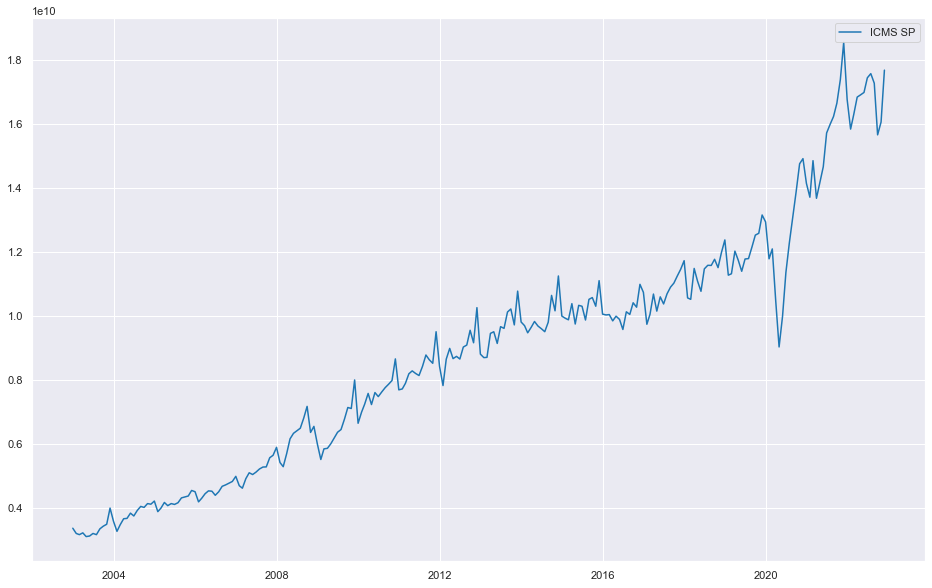

In [381]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(icms_ts, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
plt.show()

#### Últimos 24 meses da série

In [382]:
len(icms_ts['2021-01-01':'2022-12-01'])

24

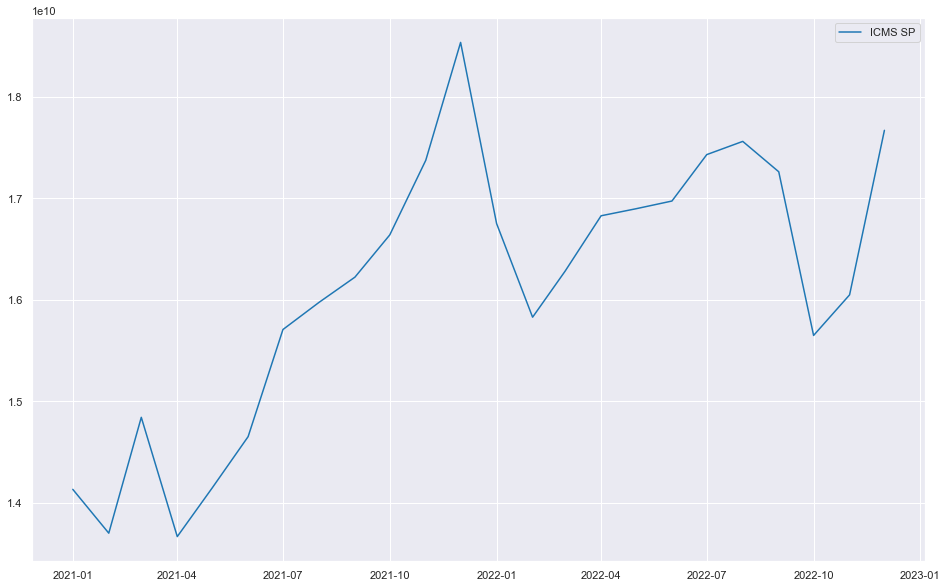

In [383]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(icms_ts['2021-01-01':'2022-12-01'], 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
plt.show()

### Série em Log
Como os valores do ICMS são muito elevados a série será colocada em log.

In [384]:
l_icms_ts = pd.Series(np.log(list(df_main['icms_sp'])), index = datas)

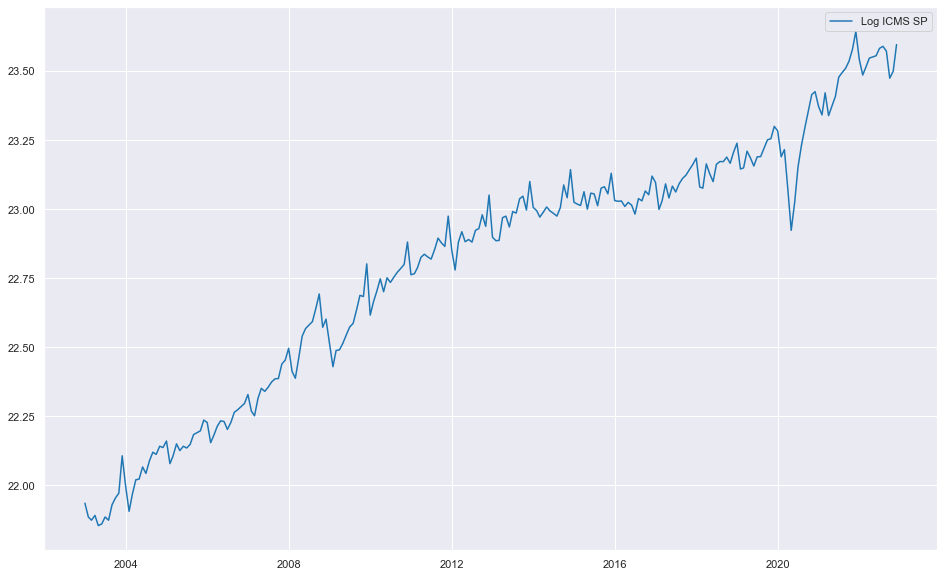

In [385]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(l_icms_ts, 'tab:blue', label='Log ICMS SP')
ax1.legend(loc='best')
plt.show()

### Série em Primeira Diferença

In [386]:
icms_ts_d1 = icms_ts.diff().dropna()
l_icms_ts_d1 = l_icms_ts.diff().dropna()

### Plotando as Séries em Primeira Diferença

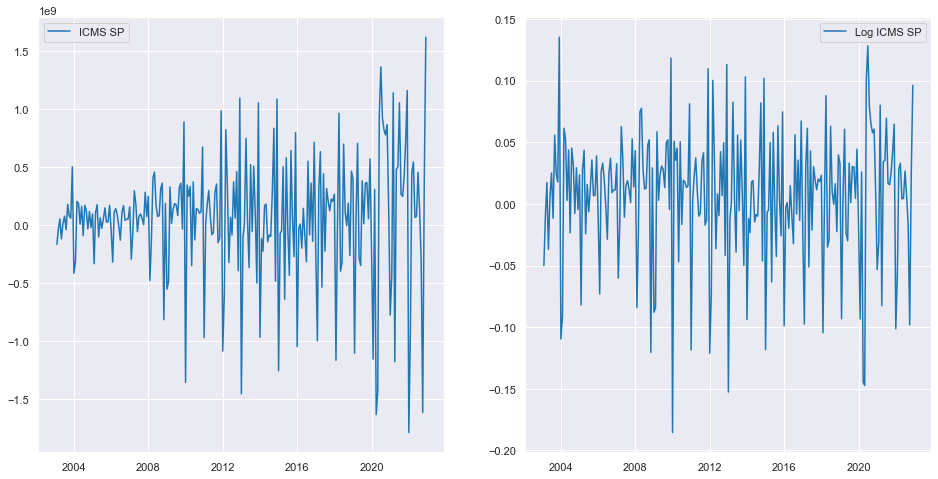

In [387]:
fig=plt.figure(figsize=(16, 8))
ax1=fig.add_subplot(121)
ax1.plot(icms_ts_d1, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2=fig.add_subplot(122)
ax2.plot(l_icms_ts_d1, 'tab:blue', label='Log ICMS SP')
ax2.legend(loc='best')
plt.show()

### Teste de Raiz Unitária da Série em Nível

Teste de raiz unitária Dickey-Fuller Aumentado (ADF): a hipótese nula é de que há raiz unitária e a série não é estacionária; a alternativa, de que não há e, portanto, a série é estacionária. 

Teste de raiz unitária Kwiatkowski-Phillips-Schmidt-Shin (KPSS): a hipótese nula é de que a série é de tendência estacionária; a alternativa é de há raiz unitária e a série não é estacionária.

A combinação dos dois testes pode ter os seguintes resultados com as seguintes consequências:

- Caso 1: Ambos os testes concluem que a série não é estacionária, então a série não é estacionária
- Caso 2: Ambos os testes concluem que a série é estacionária, então a série é estacionária
- Caso 3: o KPSS indica estacionariedade e o ADF indica não estacionariedade; a série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária. A série sem tendência deve ser verificada quanto à estacionariedade.
- Caso 4: KPSS indica não estacionariedade e ADF indica estacionariedade; a série é estacionária diferencial. A diferenciação deve ser usada para tornar as séries estacionárias. A série diferenciada deve ser verificada quanto à estacionariedade.

**Fonte**: [Statsmodel](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [388]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [389]:
adf_test(l_icms_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.388565
p-value                          0.587746
#Lags Used                      12.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64


In [390]:
kpss_test(l_icms_ts)

Results of KPSS Test:
Test Statistic            2.167822
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do ICMS em nível: a 5%, não rejeita-se a nula do teste ADF e rejeita-se do teste KPSS. A série não é estacionária em ambos os testes e precisa ser posta em primeira diferença.

### Teste de Raiz Unitária da Série em Primeira Diferença
A série posta em primeira diferença será testadas para estacionariedade com os testes ADF e KPSS.

In [391]:
adf_test(l_icms_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -4.676552
p-value                          0.000093
#Lags Used                      11.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64


In [392]:
kpss_test(l_icms_ts_d1)

Results of KPSS Test:
Test Statistic           0.075466
p-value                  0.100000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do ICMS em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em primeira diferença.

In [393]:
# Estimate the number of differences using an ADF test:
n_adf = ndiffs(icms_ts, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(icms_ts, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(icms_ts, test='pp')  # -> 0
n_adf, n_kpss, n_pp

(1, 1, 0)

### Dessazonalização da Série

In [394]:
sns.set(rc={'figure.figsize':(15,7)})

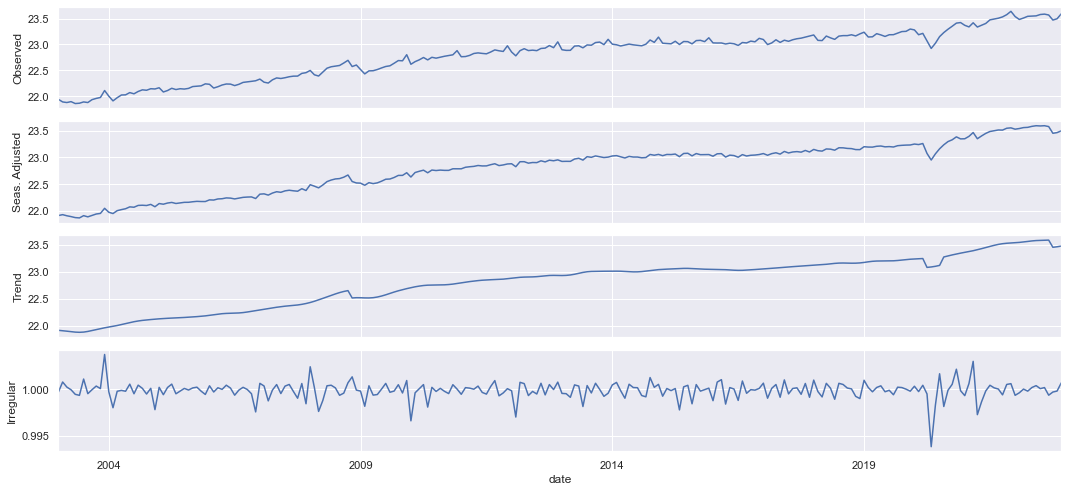

In [395]:
l_seas_icms = statsmodels.tsa.x13.x13_arima_analysis(l_icms_ts, x12path='./x13asmac/')
plot = l_seas_icms.plot()

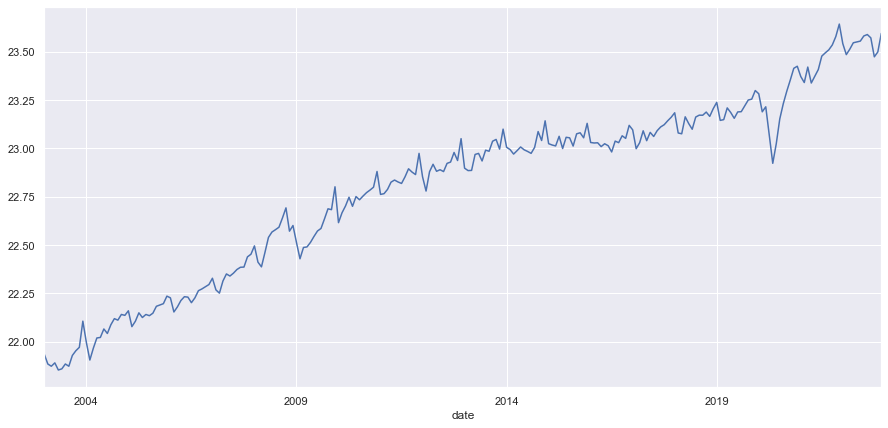

In [396]:
plot = l_seas_icms.observed.plot()

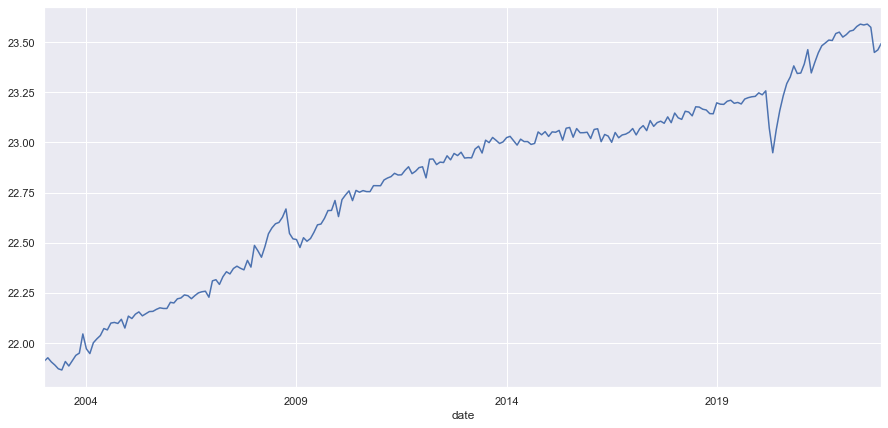

In [397]:
plot = l_seas_icms.seasadj.plot()

In [398]:
icms_decomp = pd.DataFrame(data={'ICMS observado': l_seas_icms.observed, 
                                 'ICMS desazonalizado': l_seas_icms.seasadj})

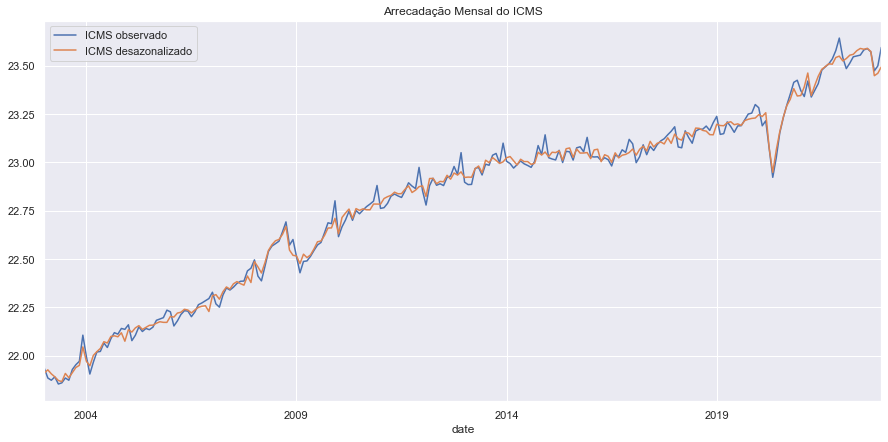

In [399]:
plot = icms_decomp.plot(title='Arrecadação Mensal do ICMS')

## Criando dummies de intervenção
Resultados do X13 Arima Seats para outliers e sazonalidade

In [400]:
pos = l_seas_icms.results.find('Outliers')
print(l_seas_icms.results[pos-309:pos+2105])

 ------------------------------------------------------------------------------
                             Parameter        Standard
 Variable                     Estimate           Error      t-value
 ------------------------------------------------------------------------------
 Automatically Identified Outliers
   LS2008.Nov                  -0.0065         0.00113        -5.75
   LS2020.Apr                  -0.0073         0.00120        -6.12
   AO2020.May                  -0.0063         0.00124        -5.03
   LS2020.Aug                   0.0059         0.00114         5.17
   LS2022.Oct                  -0.0059         0.00122        -4.88
 ------------------------------------------------------------------------------


 ARIMA Model:  (1 1 1)(1 1 1)
   Nonseasonal differences: 1
   Seasonal differences:    1
                                              Standard
 Parameter                    Estimate          Errors
 -----------------------------------------------------
 Nons

O algoritmo do ARIMA Seats X13 encontrou 4 outliers automaticamente, mas que tem explicação econômica:

**Automatically Identified Outliers**

| Variable | Parameter Estimate| Error | t-value | Explicação |
|:-|:-|:-|:-|:-|
|AO2008.Nov | -0.1401|0.02971|-4.72| Crise do Subprime |
|AO2020.Apr | -0.2147|0.02971|-7.23| Descida do V da Covid |
|AO2020.Jul |  0.1583|0.02971|5.33| Subida do V da Covid |
|AO2022.Oct | -0.1361|0.03145|-4.33| Mudanças legais na alíquota do ICMS Combustíveis, Energia Elétrica e Telecom |

Serão criadas dummies aditivas para os AO, *additive outliers*. 

In [401]:
ls2008nov = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2008nov['2008-11-01':'2022-12-01'] = 1
ls2020abr = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2020abr['2020-04-01':'2022-12-01'] = 1
ao2020mai = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ao2020mai['2020-05-01'] = 1
ls2020ago = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2020ago['2020-08-01':'2022-12-01'] = 1
ls2022out = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2022out['2022-10-01':'2022-12-01'] = 1

In [402]:
ls2008nov.shape, ls2020abr.shape, ao2020mai.shape, ls2020ago.shape, ls2022out.shape

((240,), (240,), (240,), (240,), (240,))

In [403]:
dummies_df = pd.DataFrame((ls2008nov, ls2020abr, ao2020mai, ls2020ago, ls2022out), 
                           index=['ls2008nov','ls2020abr', 'ao2020mai','ls2020ago', 'ls2022out'
                            ]).transpose()
dummies_df.head()

,ls2008nov,ls2020abr,ao2020mai,ls2020ago,ls2022out
2003-01-01,0.0,0.0,0.0,0.0,0.0
2003-02-01,0.0,0.0,0.0,0.0,0.0
2003-03-01,0.0,0.0,0.0,0.0,0.0
2003-04-01,0.0,0.0,0.0,0.0,0.0
2003-05-01,0.0,0.0,0.0,0.0,0.0


In [404]:
dummies_df.tail()

,ls2008nov,ls2020abr,ao2020mai,ls2020ago,ls2022out
2022-08-01,1.0,1.0,0.0,1.0,0.0
2022-09-01,1.0,1.0,0.0,1.0,0.0
2022-10-01,1.0,1.0,0.0,1.0,1.0
2022-11-01,1.0,1.0,0.0,1.0,1.0
2022-12-01,1.0,1.0,0.0,1.0,1.0


### Teste de Raiz Unitária Sazonal

In [405]:
D = nsdiffs(icms_ts, m=12, max_D=12, test='ch')
D

0

In [406]:
D = nsdiffs(icms_ts, m=12, max_D=12, test='ocsb')
D

0

### Separando a amostra em treinamento (in-sample) e teste (out-of-sample)
Será usada a série em log, com sazonalidade e em nível. O modelo SARIMA irá lidar com a sazonalidade e a não estacionariedade. A série out-of-sample não vai estar em log para que o resultado seja real.

In [407]:
icms_train = l_icms_ts[:-12]
icms_test = icms_ts[-12:]

In [408]:
icms_train

date
2003-01-01    21.935295
2003-02-01    21.885340
2003-03-01    21.873841
2003-04-01    21.891189
2003-05-01    21.854323
                ...    
2021-08-01    23.494311
2021-09-01    23.509795
2021-10-01    23.535116
2021-11-01    23.578358
2021-12-01    23.643073
Length: 228, dtype: float64

In [409]:
icms_test

date
2022-01-01    1.675250e+10
2022-02-01    1.582980e+10
2022-03-01    1.628352e+10
2022-04-01    1.682937e+10
2022-05-01    1.689841e+10
2022-06-01    1.697456e+10
2022-07-01    1.743210e+10
2022-08-01    1.756224e+10
2022-09-01    1.726287e+10
2022-10-01    1.565000e+10
2022-11-01    1.605000e+10
2022-12-01    1.767135e+10
dtype: float64

In [410]:
dummies = dummies_df[:].to_numpy()
dummies_train = dummies[:-12]
dummies_test = dummies[-12:]
print(dummies.shape, dummies_train.shape, dummies_test.shape)

(240, 5) (228, 5) (12, 5)


## Utilidades para Previsões

Além de MAPE e MSE, será usado o erro relativo, que é 

$Erro Relativo = \frac{|previsão - real|}{real}$

In [411]:
def erro_relativo(prev, real):
    return 100*np.absolute(prev-real)/real

#### Dicionário de Previsões
Será usado para armazenar todas as previsões.

In [412]:
previsoes = {
    'nome':[],
    'modelo': [],
    'previsoes': [],
    'rmse': [],
    'mape': [],
    'erro relativo':[]
}

## Modelos Baseline
A média e a média móvel 12 meses do ano anterior (2021) serão usadas como o baseline da previsão como modelos naïve.

### Média

In [413]:
y_mean_pred = pd.Series(np.ones(12) * icms_ts[-24:-12].mean())
y_mean_pred.index = icms_test.index
y_mean_pred

date
2022-01-01    1.546729e+10
2022-02-01    1.546729e+10
2022-03-01    1.546729e+10
2022-04-01    1.546729e+10
2022-05-01    1.546729e+10
2022-06-01    1.546729e+10
2022-07-01    1.546729e+10
2022-08-01    1.546729e+10
2022-09-01    1.546729e+10
2022-10-01    1.546729e+10
2022-11-01    1.546729e+10
2022-12-01    1.546729e+10
dtype: float64

In [414]:
previsoes['nome'].append('Mean')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_mean_pred)

In [415]:
RMSE_mean = mean_squared_error(icms_test, y_mean_pred, squared=False)
previsoes['rmse'].append(RMSE_mean)
RMSE_mean

1452835145.7299118

In [416]:
MAPE_mean = mean_absolute_percentage_error(icms_test, y_mean_pred)
previsoes['mape'].append(MAPE_mean)
MAPE_mean

0.07607343139490706

In [417]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_mean_pred, icms_test)])

### Comparação do modelo naïve com o real

In [418]:
prev_naive_df = pd.DataFrame(data={"Mean": previsoes['previsoes'][0]})
prev_naive_df['real'] = icms_test
prev_naive_df

,Mean,real
date,,
2022-01-01,1.546729e+10,1.675250e+10
2022-02-01,1.546729e+10,1.582980e+10
2022-03-01,1.546729e+10,1.628352e+10
2022-04-01,1.546729e+10,1.682937e+10
2022-05-01,1.546729e+10,1.689841e+10
2022-06-01,1.546729e+10,1.697456e+10
2022-07-01,1.546729e+10,1.743210e+10
2022-08-01,1.546729e+10,1.756224e+10
2022-09-01,1.546729e+10,1.726287e+10


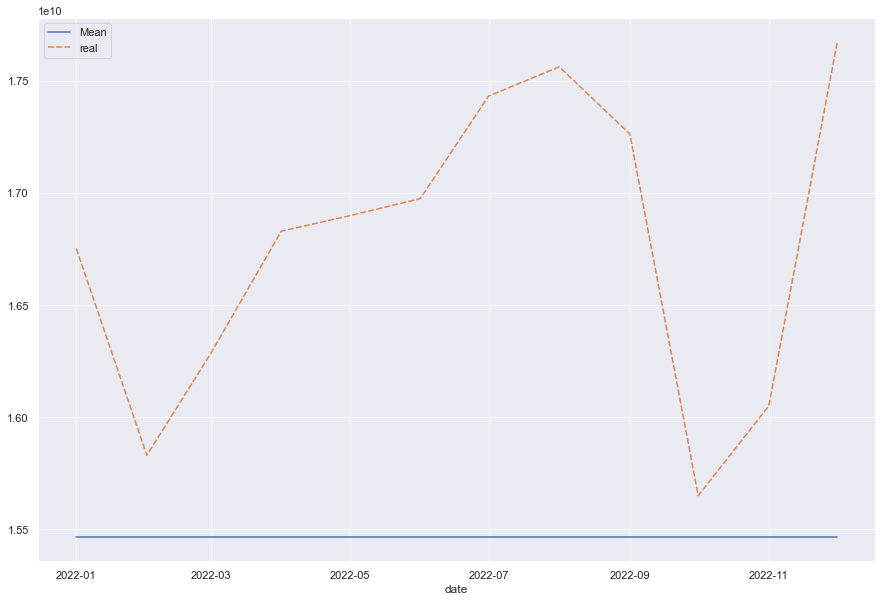

In [419]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_naive_df)

## Modelos ARIMA sem Dummies de Intervenção

### Auto Arima da Série

#### Critério de Akaike

In [420]:
mod_aa_aic = auto_arima(icms_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_aic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True)

#### Critério de Schwarz

In [421]:
mod_aa_bic = auto_arima(icms_train, stationary=False, seasonal=True, m=12,
                        information_criterion='bic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_bic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMA(0,1,1),(2,0,1) sugerido pelo critério de Akaike

In [422]:
mod_arima1 = ARIMA(icms_train, order=(0,1,1), seasonal_order=(2,0,1,12))
res_arima1 = mod_arima1.fit()
print(res_arima1.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  228
Model:             ARIMA(0, 1, 1)x(2, 0, 1, 12)   Log Likelihood                 394.129
Date:                          Sun, 25 Jun 2023   AIC                           -778.258
Time:                                  17:35:05   BIC                           -761.133
Sample:                              01-01-2003   HQIC                          -771.348
                                   - 12-01-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2707      0.044     -6.111      0.000      -0.357      -0.184
ar.S.L12       1.2834      0.128     10.050      0.

#### Análise dos Resíduos

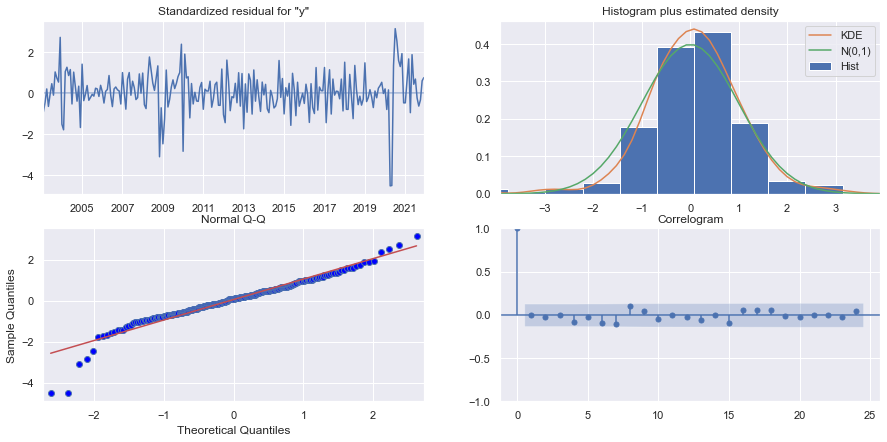

In [423]:
ax = res_arima1.plot_diagnostics(lags=24)

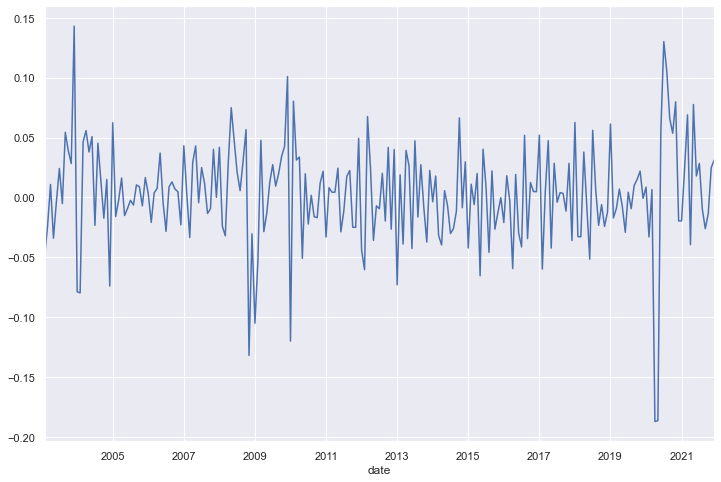

In [424]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima1.resid[1:].plot(ax=ax)

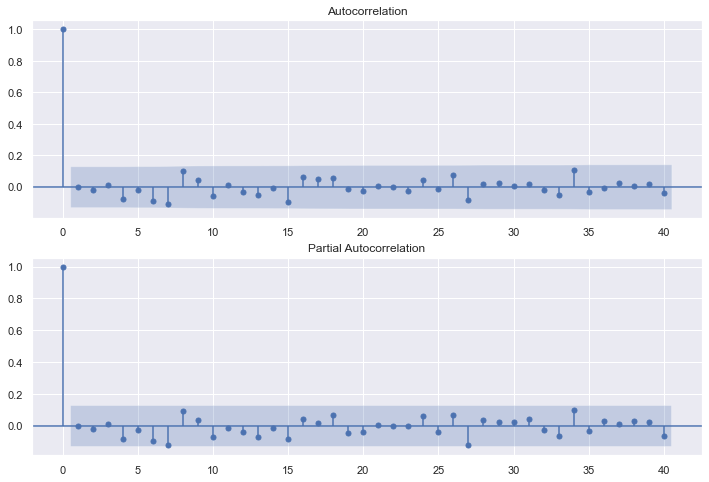

In [425]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima1.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima1.resid[1:], lags=40, ax=ax2)

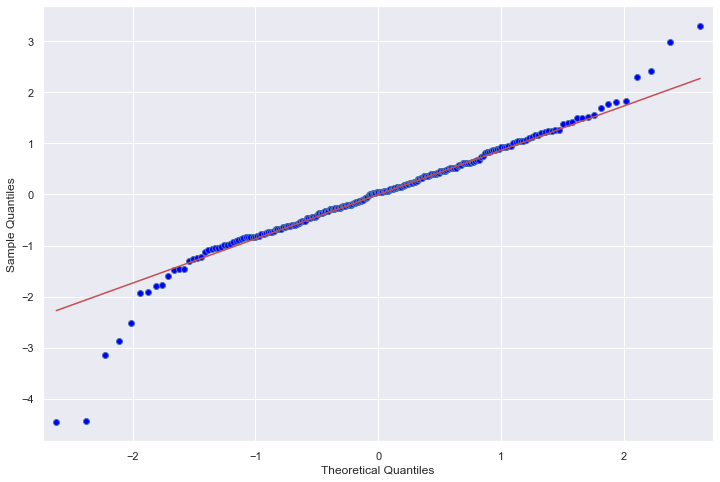

In [426]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima1.resid[1:], line="q", ax=ax, fit=True)

#### Previsões

In [427]:
previsoes['nome'].append('SARIMA(0,1,1),(2,0,1)')
previsoes['modelo'].append(res_arima1)

In [428]:
y_arima1_pred = np.exp(res_arima1.forecast(12))
previsoes['previsoes'].append(y_arima1_pred)

In [429]:
RMSE_arima1 = mean_squared_error(icms_test, y_arima1_pred, squared=False)
previsoes['rmse'].append(RMSE_arima1)
RMSE_arima1

1866080918.8510065

In [430]:
MAPE_arima1 = mean_absolute_percentage_error(icms_test, y_arima1_pred)
previsoes['mape'].append(MAPE_arima1)
MAPE_arima1

0.08852852819570212

In [431]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima1_pred, icms_test)])

### Modelo SARIMA(0,1,1),(1,0,1) sugerido pelo critério de Schwarz

In [432]:
mod_arima2 = ARIMA(icms_train, order=(0,1,1), seasonal_order=(1,0,1,12))
res_arima2 = mod_arima2.fit()
print(res_arima2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  228
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 391.426
Date:                          Sun, 25 Jun 2023   AIC                           -774.851
Time:                                  17:35:08   BIC                           -761.151
Sample:                              01-01-2003   HQIC                          -769.323
                                   - 12-01-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2783      0.039     -7.228      0.000      -0.354      -0.203
ar.S.L12       0.9075      0.045     20.136      0.

#### Análise dos Resíduos

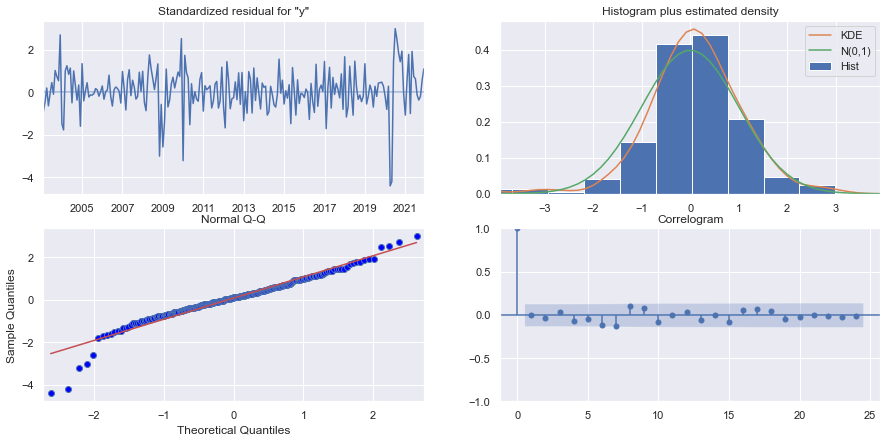

In [433]:
ax = res_arima2.plot_diagnostics(lags=24)

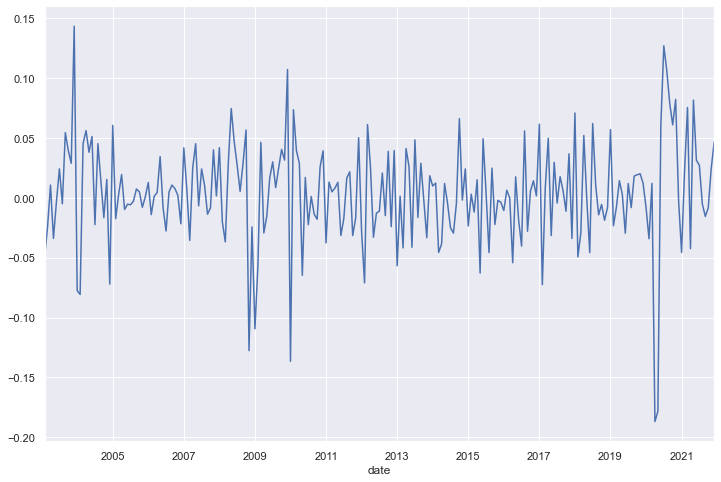

In [434]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima2.resid[1:].plot(ax=ax)

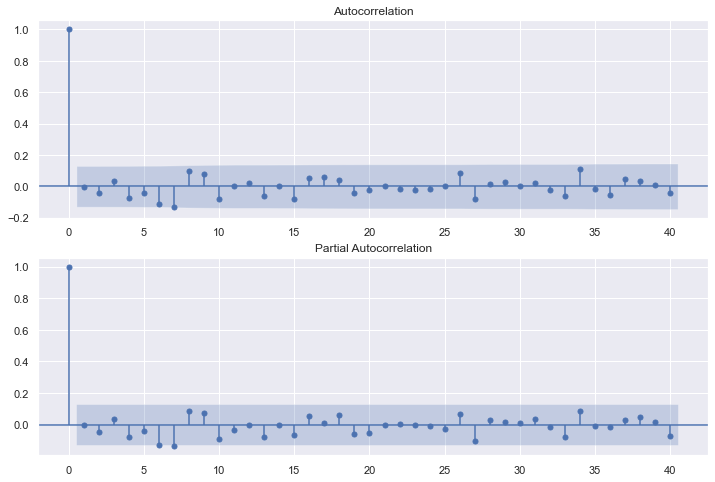

In [435]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima2.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima2.resid[1:], lags=40, ax=ax2)

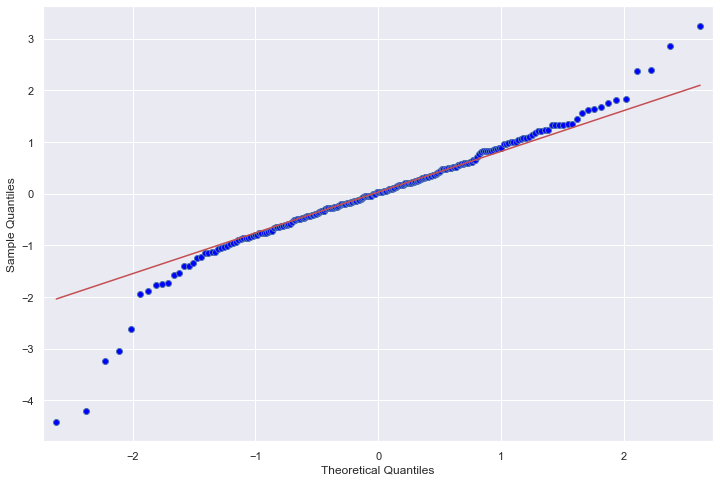

In [436]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima2.resid[1:], line="q", ax=ax, fit=True)

#### Previsões

In [437]:
previsoes['nome'].append('SARIMA(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima2)

In [438]:
y_arima2_pred = np.exp(res_arima2.forecast(12))
previsoes['previsoes'].append(y_arima2_pred)

In [439]:
RMSE_arima2 = mean_squared_error(icms_test, y_arima2_pred, squared=False)
previsoes['rmse'].append(RMSE_arima2)
RMSE_arima2

1850801678.8041606

In [440]:
MAPE_arima2 = mean_absolute_percentage_error(icms_test, y_arima2_pred)
previsoes['mape'].append(MAPE_arima2)
MAPE_arima2

0.08523875308627767

In [441]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima2_pred, icms_test)])

In [442]:
prev_arma_df = pd.DataFrame(data={"SARIMA(0,1,1),(2,0,1)": previsoes['previsoes'][1],
                                 "SARIMA(0,1,1),(1,0,1)": previsoes['previsoes'][2]})
prev_arma_df['real'] = icms_test
prev_arma_df

,"SARIMA(0,1,1),(2,0,1)","SARIMA(0,1,1),(1,0,1)",real
2022-01-01,1.748345e+10,1.790502e+10,1.675250e+10
2022-02-01,1.678663e+10,1.705301e+10,1.582980e+10
2022-03-01,1.740136e+10,1.760160e+10,1.628352e+10
2022-04-01,1.723516e+10,1.695666e+10,1.682937e+10
2022-05-01,1.727624e+10,1.655464e+10,1.689841e+10
2022-06-01,1.761164e+10,1.700425e+10,1.697456e+10
2022-07-01,1.815622e+10,1.791732e+10,1.743210e+10
2022-08-01,1.844449e+10,1.833003e+10,1.756224e+10
2022-09-01,1.888572e+10,1.874536e+10,1.726287e+10
2022-10-01,1.930925e+10,1.922765e+10,1.565000e+10


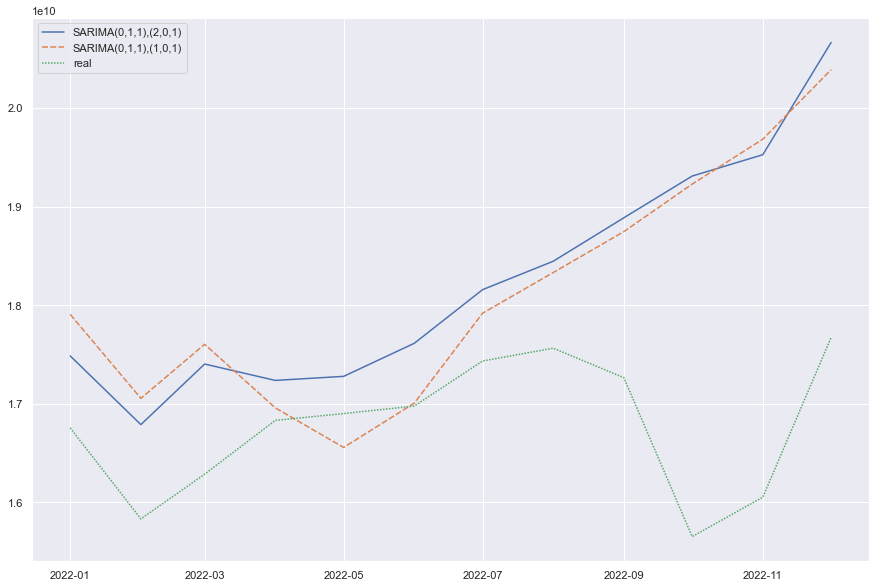

In [443]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

## Modelos ARIMA com Dummies de Intervenção

### Auto Arima da Série

#### Critério de Akaike

In [444]:
mod_aa_aic_dum = auto_arima(icms_train, X=dummies_train, d=1, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_aic_dum

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

#### Critério de Schwarz

In [445]:
mod_aa_bic_dum = auto_arima(icms_train, x=dummies_train, d=1, stationary=False, seasonal=True, m=12, 
                        information_criterion='bic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_bic_dum

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMAX(0,1,1),(2,0,0) sugerido pelo critério de Akaike
Mesmo modelo sugerido para a série sem as dummies de intervenção.

In [446]:
mod_arima3 = ARIMA(icms_train, exog=dummies_train, order=(0,1,1), seasonal_order=(2,0,0,12))
res_arima3 = mod_arima3.fit()
print(res_arima3.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  228
Model:             ARIMA(0, 1, 1)x(2, 0, [], 12)   Log Likelihood                 432.284
Date:                           Sun, 25 Jun 2023   AIC                           -846.568
Time:                                   17:36:34   BIC                           -815.743
Sample:                               01-01-2003   HQIC                          -834.130
                                    - 12-01-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1445      0.027     -5.390      0.000      -0.197      -0.092
x2            -0.1628      0.026     -6.176

#### Análise dos Resíduos

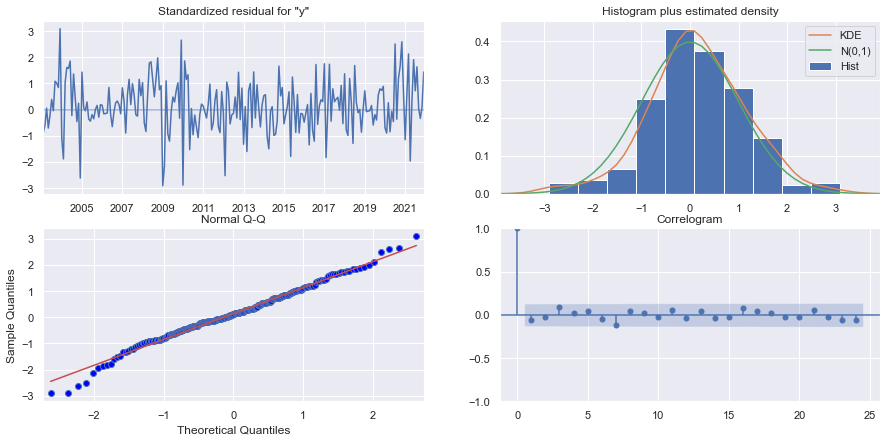

In [447]:
ax = res_arima3.plot_diagnostics(lags=24)

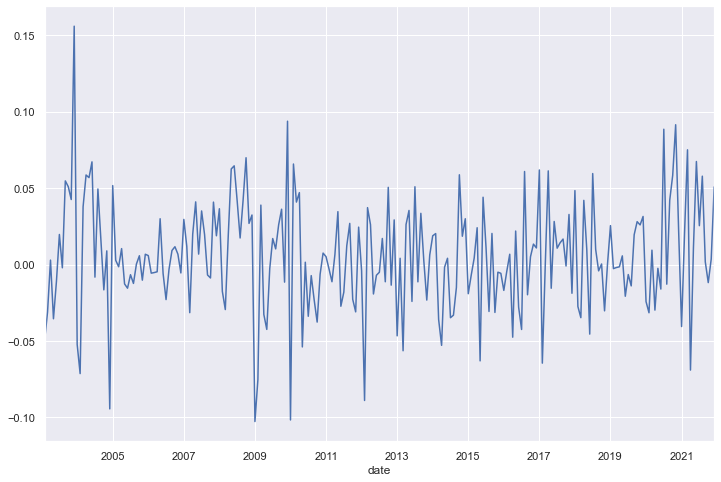

In [448]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima3.resid[1:].plot(ax=ax)

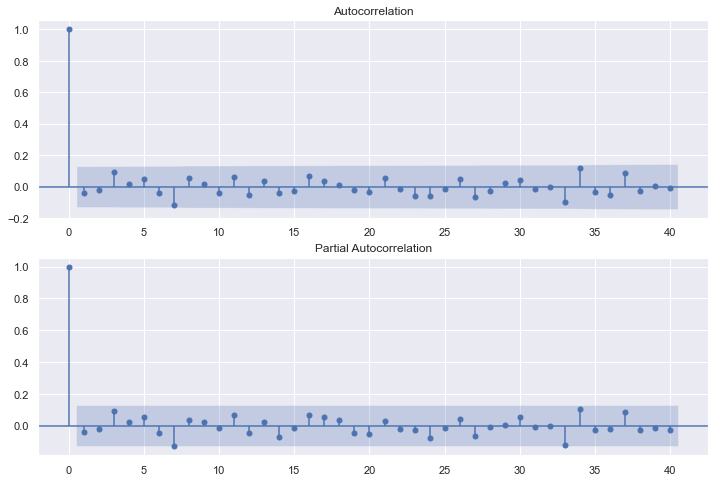

In [449]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima3.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima3.resid[1:], lags=40, ax=ax2)

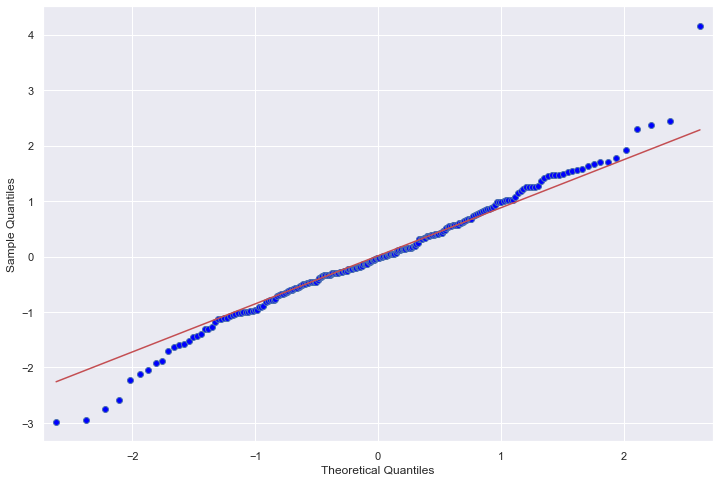

In [450]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima3.resid[1:], line="q", ax=ax, fit=True)

### Previsões

In [451]:
previsoes['nome'].append('SARIMAX(0,1,1),(2,0,0)')
previsoes['modelo'].append(res_arima3)

In [452]:
y_arima3_pred = np.exp(res_arima3.forecast(12, exog=dummies_test))
previsoes['previsoes'].append(y_arima3_pred)

In [453]:
RMSE_arima3 = mean_squared_error(icms_test, y_arima3_pred, squared=False)
previsoes['rmse'].append(RMSE_arima3)
RMSE_arima3

2139218646.3975534

In [454]:
MAPE_arima3 = mean_absolute_percentage_error(icms_test, y_arima3_pred)
previsoes['mape'].append(MAPE_arima3)
MAPE_arima3

0.10034673797256216

In [455]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima3_pred, icms_test)])

### Modelo SARIMAX(0,1,1),(1,0,1) sugerido pelo critério de Schwartz
Mesmo modelo sugerido para a série sem as dummies de intervenção.

In [456]:
mod_arima4 = ARIMA(icms_train, exog=dummies_train, order=(0,1,1), seasonal_order=(1,0,1,12))
res_arima4 = mod_arima4.fit()
print(res_arima4.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  228
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 433.782
Date:                          Sun, 25 Jun 2023   AIC                           -849.564
Time:                                  17:36:37   BIC                           -818.740
Sample:                              01-01-2003   HQIC                          -837.126
                                   - 12-01-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1380      0.030     -4.640      0.000      -0.196      -0.080
x2            -0.1638      0.028     -5.778      0.

#### Análise dos Resíduos

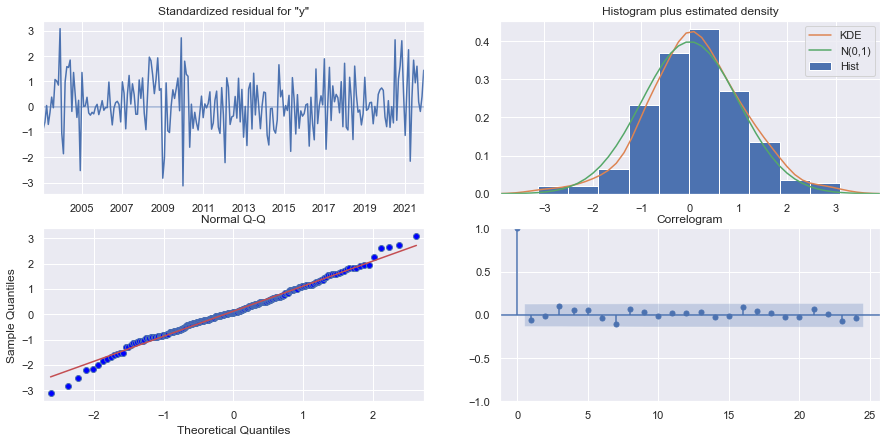

In [457]:
ax = res_arima4.plot_diagnostics(lags=24)

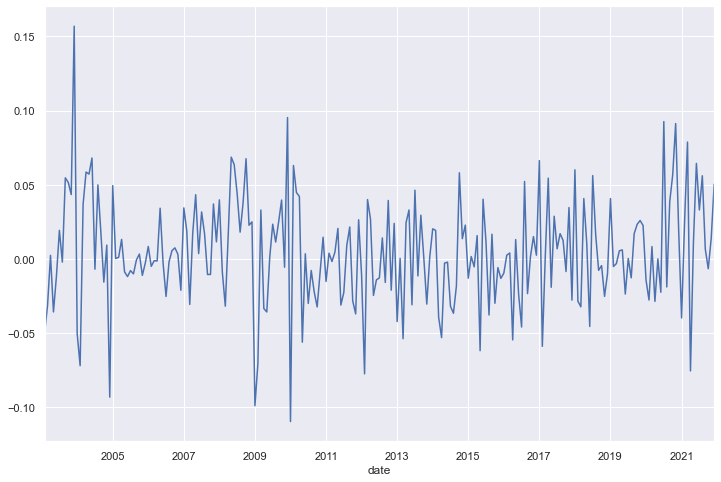

In [458]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima4.resid[1:].plot(ax=ax)

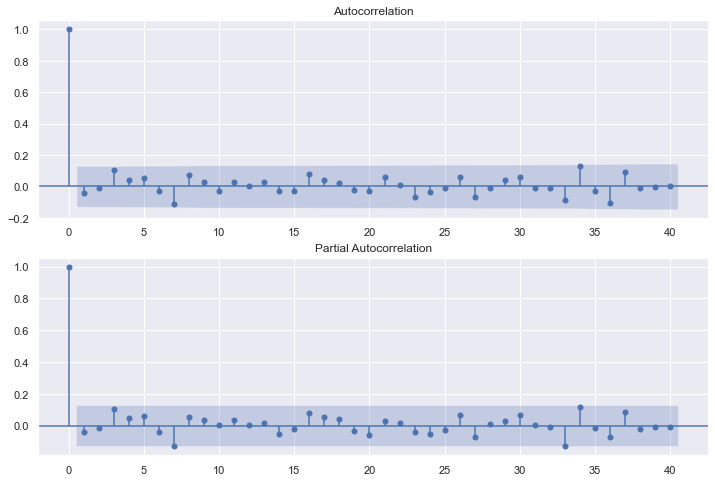

In [459]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima4.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima4.resid[1:], lags=40, ax=ax2)

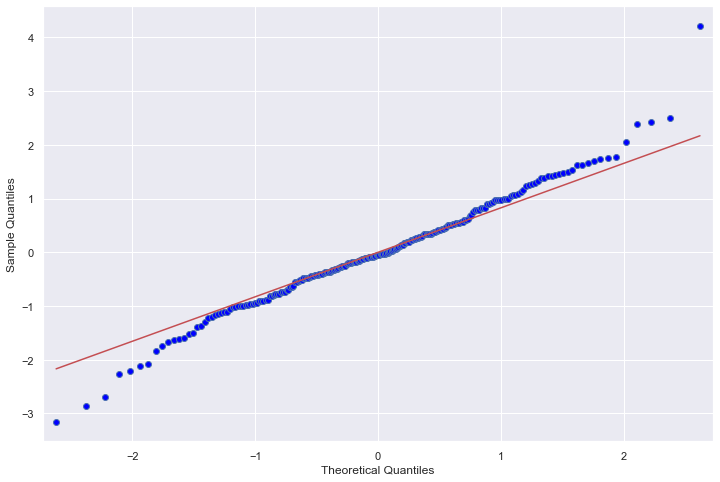

In [460]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima4.resid[1:], line="q", ax=ax, fit=True)

### Previsões

In [461]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima4)

In [462]:
y_arima4_pred = np.exp(res_arima4.forecast(12, exog=dummies_test))
previsoes['previsoes'].append(y_arima4_pred)

In [463]:
RMSE_arima4 = mean_squared_error(icms_test, y_arima4_pred, squared=False)
previsoes['rmse'].append(RMSE_arima4)
RMSE_arima4

1993289484.4971905

In [464]:
MAPE_arima4 = mean_absolute_percentage_error(icms_test, y_arima4_pred)
previsoes['mape'].append(MAPE_arima4)
MAPE_arima4

0.09329221786380905

In [465]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima4_pred, icms_test)])

### Comparação dos modelos SARIMA

In [466]:
prev_arma_df = pd.DataFrame(data={"SARIMA(0,1,1),(2,0,1)": previsoes['previsoes'][1],
                                 "SARIMA(0,1,1),(1,0,1)": previsoes['previsoes'][2],
                                 "SARIMAX(0,1,1),(1,0,2)": previsoes['previsoes'][3],
                                 "SARIMAX(0,1,1),(1,0,1)": previsoes['previsoes'][4]})
prev_arma_df['real'] = icms_test
prev_arma_df

,"SARIMA(0,1,1),(2,0,1)","SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,2)","SARIMAX(0,1,1),(1,0,1)",real
2022-01-01,1.748345e+10,1.790502e+10,1.750645e+10,1.762553e+10,1.675250e+10
2022-02-01,1.678663e+10,1.705301e+10,1.686397e+10,1.679506e+10,1.582980e+10
2022-03-01,1.740136e+10,1.760160e+10,1.771377e+10,1.751425e+10,1.628352e+10
2022-04-01,1.723516e+10,1.695666e+10,1.700419e+10,1.712871e+10,1.682937e+10
2022-05-01,1.727624e+10,1.655464e+10,1.729202e+10,1.727937e+10,1.689841e+10
2022-06-01,1.761164e+10,1.700425e+10,1.748070e+10,1.736553e+10,1.697456e+10
2022-07-01,1.815622e+10,1.791732e+10,1.867268e+10,1.848584e+10,1.743210e+10
2022-08-01,1.844449e+10,1.833003e+10,1.862562e+10,1.843260e+10,1.756224e+10
2022-09-01,1.888572e+10,1.874536e+10,1.905212e+10,1.887475e+10,1.726287e+10
2022-10-01,1.930925e+10,1.922765e+10,1.956299e+10,1.939979e+10,1.565000e+10


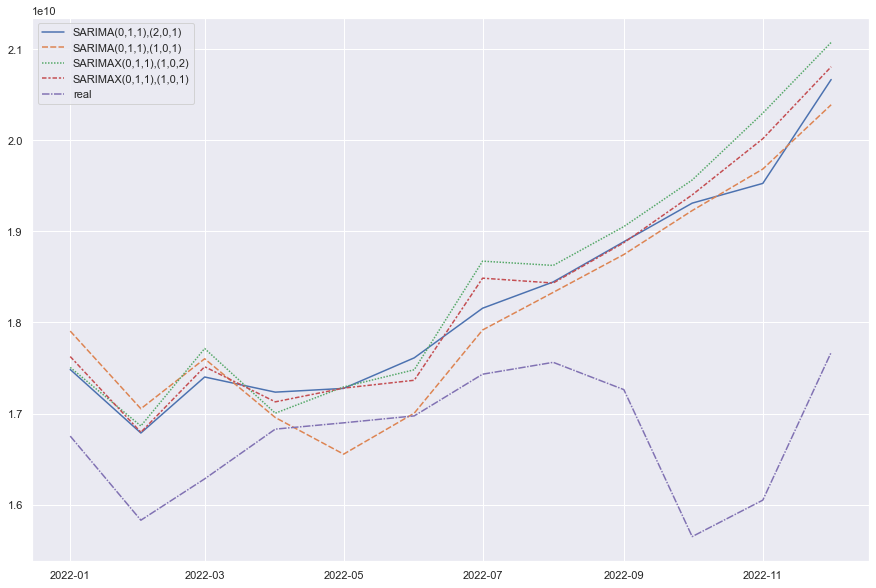

In [467]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

## Modelo de Markov-Switching

A biblioteca statsmodel não tem implementado o método de forecast do modelo de Markov Switching. Por isso o forecast foi realizado no Ox e os dados estão sendo importados aqui.
Foram feitos 3 modelos usando as mesmas variáveis e 2 mudanças de regime:
- log icms em primeira diferença - Y
- constante - mudança de regime (*regime switching*)
- loc icms em primeira diferença com uma defasagem - (*regime switching*) 
- 11 dummies sazonais - X (variável)

E foram usados 3 tipos de variância
- variância fixa (*fixed variance*)
- mudança de variância (*switching variance*)
- componente média-variância (*mean-variance component*)

In [468]:
markov_forecast_df = pd.read_csv('forecast_markov.csv', delimiter=';', decimal=',')
markov_forecast_df = markov_forecast_df[-12:]

### Variância Fixa

In [3]:
arq1 = open('./ox/22_results_uni_fixed.txt', 'r')
print(arq1.read())
arq1.close()

Ox Professional version 8.20 (OS_X_64/U) (C) J.A. Doornik, 1994-2019

---- Switching - PcGive 2.08 session started at 17:39:01 on 23-05-2023 ----

Switching( 1) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final_diff/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-03-01 - 2021-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal         -0.0912685     0.01317    -6.93   0.000
CSeasonal_1        -0.148519     0.01563    -9.50   0.000
CSeasonal_2       -0.0632533     0.01481    -4.27   0.000
CSeasonal_3       -0.0245879     0.01311    -1.87   0.062
CSeasonal_4       -0.0599106     0.01400    -4.28   0.000
CSeasonal_5       -0.0601961     0.01365    -4.41   0.000
CSeasonal_6       -0.0490031     0.01274    -3.85   0.000
CSeasonal_7       -0.0465071     0.01279    -3.64   0.000
CSeasonal_8       -0.0274183     0.01257    -2.18   0.030
CSeasonal_9       -0.0287015     0.01292    -2.2

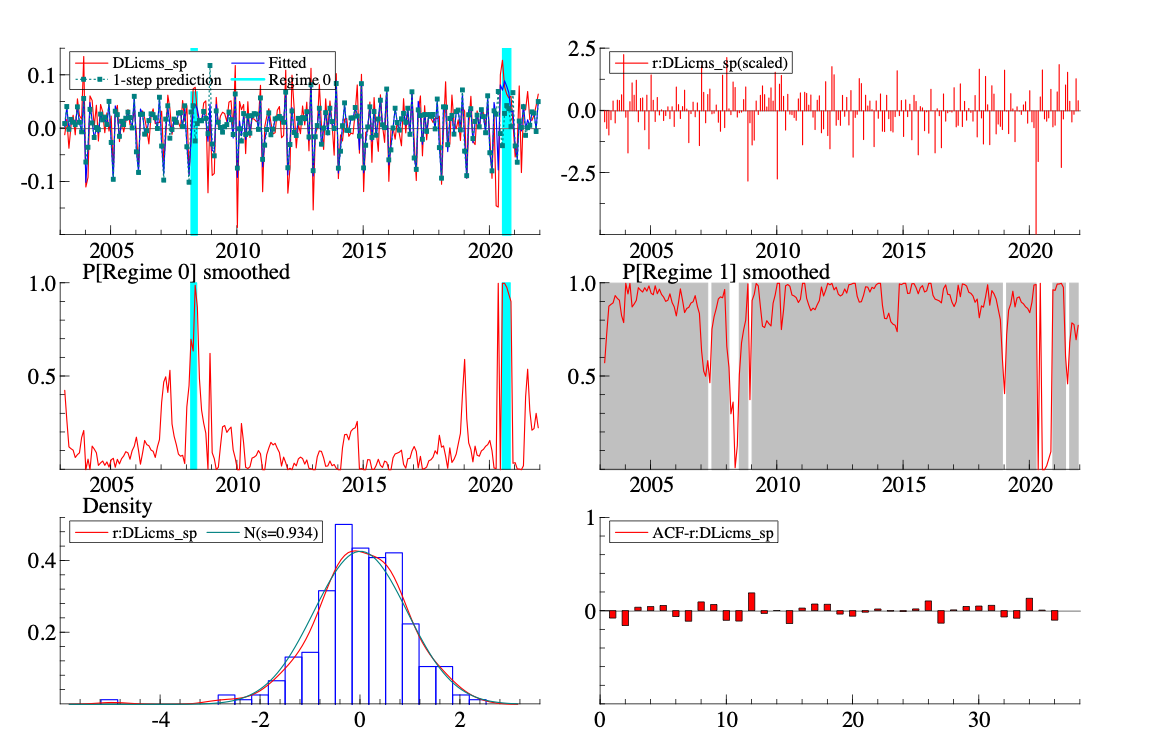

#### Previsões

In [470]:
y_markov_fixed_pred = np.exp(np.cumsum(markov_forecast_df['22_forecast_uni_fixed'])+icms_train[-1])
y_markov_fixed_pred.index = icms_test.index
y_markov_fixed_pred

date
2022-01-01    1.763949e+10
2022-02-01    1.648776e+10
2022-03-01    1.690296e+10
2022-04-01    1.740629e+10
2022-05-01    1.727216e+10
2022-06-01    1.737543e+10
2022-07-01    1.758465e+10
2022-08-01    1.780022e+10
2022-09-01    1.836415e+10
2022-10-01    1.878566e+10
2022-11-01    1.870155e+10
2022-12-01    1.995620e+10
Name: 22_forecast_uni_fixed, dtype: float64

In [471]:
previsoes['nome'].append('Markov-Fixed')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_fixed_pred)

In [472]:
RMSE_markov_fixed = mean_squared_error(icms_test, y_markov_fixed_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_fixed)
RMSE_markov_fixed

1460960954.7287006

In [473]:
MAPE_markov_fixed = mean_absolute_percentage_error(icms_test, y_markov_fixed_pred)
previsoes['mape'].append(MAPE_markov_fixed)
MAPE_markov_fixed

0.0661271935828156

In [474]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_fixed_pred, icms_test)])

### Modelo com Mudança de Variância

In [475]:
arq2 = open('./ox/22_results_uni_var.txt', 'r')
print(arq2.read())
arq2.close()


Ox Professional version 8.20 (OS_X_64/U) (C) J.A. Doornik, 1994-2019

---- Switching - PcGive 2.08 session started at 17:52:31 on 23-05-2023 ----

Switching( 1) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final_diff/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-03-01 - 2021-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal         -0.0920864     0.01230    -7.48   0.000
CSeasonal_1        -0.146678     0.01168    -12.6   0.000
CSeasonal_2       -0.0698385     0.01138    -6.14   0.000
CSeasonal_3       -0.0171556     0.01110    -1.55   0.124
CSeasonal_4       -0.0560157     0.01119    -5.01   0.000
CSeasonal_5       -0.0613883     0.01091    -5.63   0.000
CSeasonal_6       -0.0544991     0.01095    -4.98   0.000
CSeasonal_7       -0.0465791     0.01077    -4.32   0.000
CSeasonal_8       -0.0278081     0.01079    -2.58   0.011
CSeasonal_9       -0.0292780     0.01091    -2.

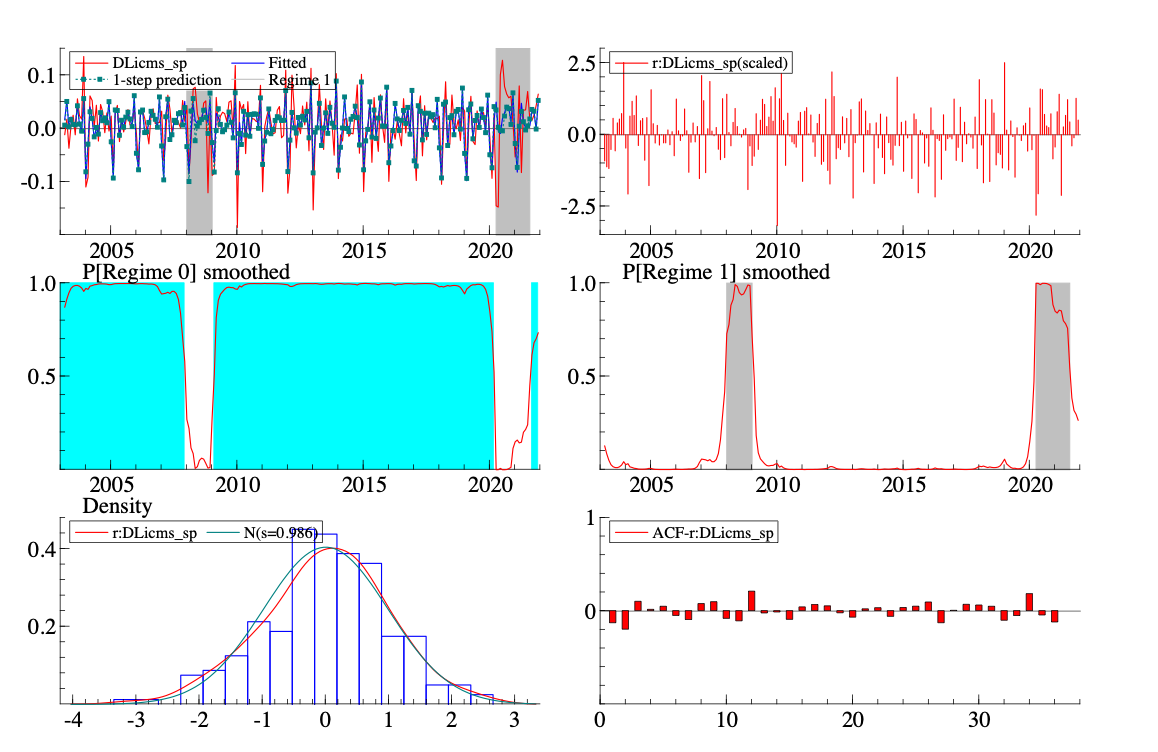

#### Previsões

In [476]:
y_markov_switching_pred = np.exp(np.cumsum(markov_forecast_df['22_forecast_uni_var'])+icms_train[-1])
y_markov_switching_pred.index = icms_test.index
y_markov_switching_pred

date
2022-01-01    1.762676e+10
2022-02-01    1.654143e+10
2022-03-01    1.684865e+10
2022-04-01    1.755058e+10
2022-05-01    1.743551e+10
2022-06-01    1.753977e+10
2022-07-01    1.768155e+10
2022-08-01    1.795134e+10
2022-09-01    1.851876e+10
2022-10-01    1.895572e+10
2022-11-01    1.891368e+10
2022-12-01    2.019878e+10
Name: 22_forecast_uni_var, dtype: float64

In [477]:
previsoes['nome'].append('Markov-Switching-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_switching_pred)

In [478]:
RMSE_markov_switching = mean_squared_error(icms_test, y_markov_switching_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_switching)
RMSE_markov_switching

1581809062.7990727

In [479]:
MAPE_markov_switching = mean_absolute_percentage_error(icms_test, y_markov_switching_pred)
previsoes['mape'].append(MAPE_markov_switching)
MAPE_markov_switching

0.07347289055035207

In [480]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_switching_pred, icms_test)])

### Componente Média-Variância

In [4]:
arq3 = open('./ox/22_results_uni_mean_var.txt', 'r')
print(arq3.read())
arq3.close()

---- OxMetrics 8.10 started at 01:13:33 on 06-Jul-2023 ----

OxMetrics-8

variaveis_previsao.xlsx loaded from /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx


Ox Professional version 8.20 (OS_X_64/U) (C) J.A. Doornik, 1994-2019

---- PcGive 15.20 session started at  1:13:51 on  6-07-2023 ----

---- Switching - PcGive 2.08 session started at  1:13:57 on  6-07-2023 ----

Switching( 1) Modelling DLicms_sp by MS_Component(2, 2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-03-01 - 2021-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal         -0.0797995     0.01383    -5.77   0.000
CSeasonal_1        -0.147890     0.01177    -12.6   0.000
CSeasonal_2       -0.0524688     0.01192    -4.40   0.000
CSeasonal_3      -0.00907992     0.01094   -0.830   0.408
CSeasonal_4       -0.0504436     0.01104    -4.57   0.000
CSeasonal_5 

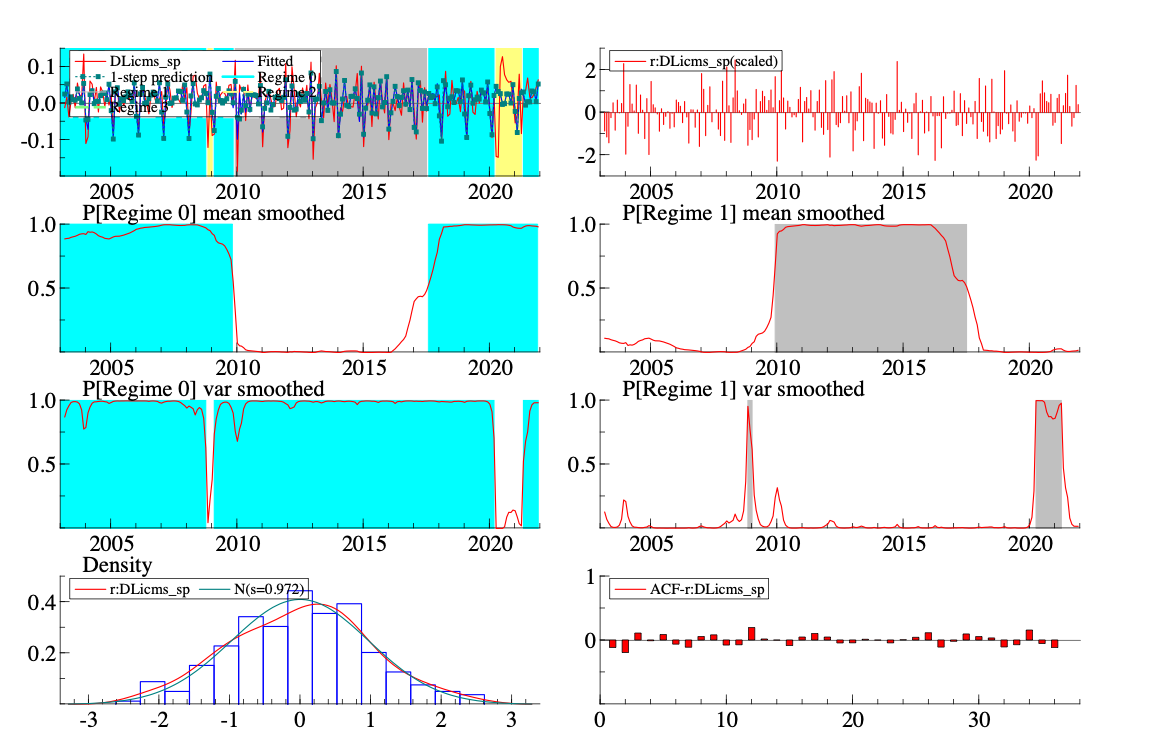

#### Previsões

In [482]:
y_markov_mean_var_pred = np.exp(np.cumsum(markov_forecast_df['22_forecast_uni_mean_var'])+icms_train[-1])
y_markov_mean_var_pred.index = icms_test.index
y_markov_mean_var_pred

date
2022-01-01    1.800114e+10
2022-02-01    1.655124e+10
2022-03-01    1.688344e+10
2022-04-01    1.770180e+10
2022-05-01    1.772669e+10
2022-06-01    1.783509e+10
2022-07-01    1.804618e+10
2022-08-01    1.831681e+10
2022-09-01    1.894641e+10
2022-10-01    1.948064e+10
2022-11-01    1.954744e+10
2022-12-01    2.072858e+10
Name: 22_forecast_uni_mean_var, dtype: float64

In [483]:
previsoes['nome'].append('Markov-Mean-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_mean_var_pred)

In [484]:
RMSE_markov_mean_var = mean_squared_error(icms_test, y_markov_mean_var_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_mean_var)
RMSE_markov_mean_var

1929173127.4479458

In [485]:
MAPE_markov_mean_var = mean_absolute_percentage_error(icms_test, y_markov_mean_var_pred)
previsoes['mape'].append(MAPE_markov_mean_var)
MAPE_markov_mean_var

0.09332516414404579

In [486]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_mean_var_pred, icms_test)])

#### Resultados dos Modelos de Markov

In [487]:
previsoes['nome']

['Mean',
 'SARIMA(0,1,1),(2,0,1)',
 'SARIMA(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(2,0,0)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var']

In [488]:
prev_markov_df = pd.DataFrame(data={previsoes['nome'][5]: previsoes['previsoes'][5],
                                    previsoes['nome'][6]: previsoes['previsoes'][6],
                                    previsoes['nome'][7]: previsoes['previsoes'][7]
                                   })
prev_markov_df['real'] = icms_test
prev_markov_df

,Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,real
date,,,,
2022-01-01,1.763949e+10,1.762676e+10,1.800114e+10,1.675250e+10
2022-02-01,1.648776e+10,1.654143e+10,1.655124e+10,1.582980e+10
2022-03-01,1.690296e+10,1.684865e+10,1.688344e+10,1.628352e+10
2022-04-01,1.740629e+10,1.755058e+10,1.770180e+10,1.682937e+10
2022-05-01,1.727216e+10,1.743551e+10,1.772669e+10,1.689841e+10
2022-06-01,1.737543e+10,1.753977e+10,1.783509e+10,1.697456e+10
2022-07-01,1.758465e+10,1.768155e+10,1.804618e+10,1.743210e+10
2022-08-01,1.780022e+10,1.795134e+10,1.831681e+10,1.756224e+10
2022-09-01,1.836415e+10,1.851876e+10,1.894641e+10,1.726287e+10


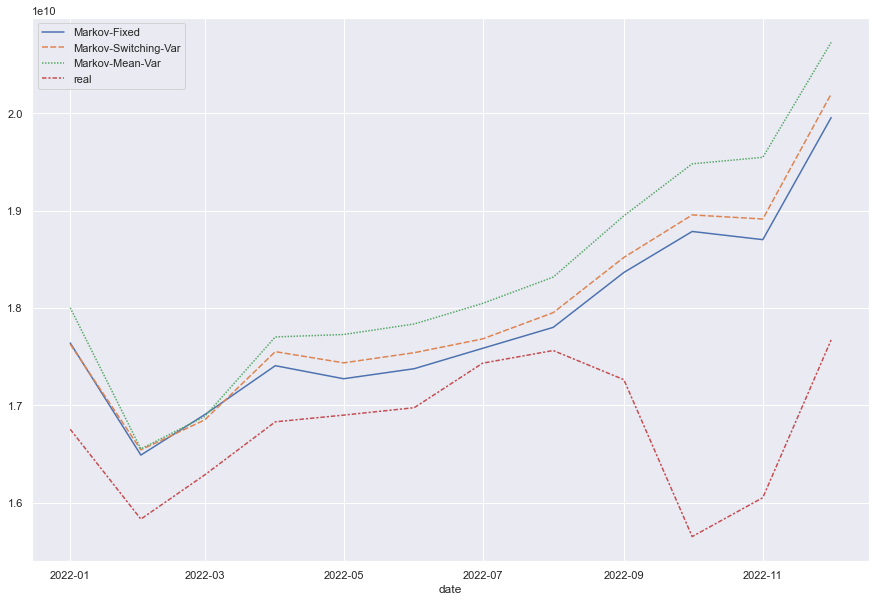

In [489]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_markov_df)

## Modelos RNN LSTM
Redes Neurais Recorrentes com neurônios Long Short-Term Memory

### Montagem da Série
As redes neurais precisam de conjuntos de características e de etiquetas separados. Neste caso, o conjunto de etiquetas é a própria série de ICMS. Para os conjunto de caraterísticas será utilizada a série do ICMS com lags 1, 2, 3, 4, 6 e 12 defasagens, e médias móveis de 2, 3, 6 e 12 meses, conforme trabalho de [Silva & Figueiredo, 2020].

In [490]:
def cria_features_target(serie, verbose=0):
    serie_d1 = serie.shift(1)
    serie_d2 = serie.shift(2)
    serie_d3 = serie.shift(3)
    serie_d4 = serie.shift(4)
    serie_d6 = serie.shift(6)
    serie_d12 = serie.shift(12)
    serie_ma2 = serie.rolling(2).mean()
    serie_ma3 = serie.rolling(3).mean()
    serie_ma6 = serie.rolling(6).mean()
    serie_ma12 = serie.rolling(12).mean()

    if verbose==1:
        print("shape de cada uma das séries:")
        print(serie_d1.shape, serie_d2.shape, serie_d3.shape, serie_d4.shape, 
              serie_d6.shape, serie_d12.shape, serie_ma2.shape, serie_ma3.shape, 
              serie_ma6.shape, serie_ma12.shape)
    X = np.array([serie_d1, serie_d2, serie_d3, serie_d4, 
     serie_d6, serie_d12, serie_ma2, serie_ma3, 
     serie_ma6, serie_ma12])
    if verbose==1:
        print("shape do array de features:", X.shape)
    X = X[:,12:]
    X = X.T
    if verbose==1:
        print("shape do array de features depois da poda e da transposição:", X.shape)
    Y = np.array(serie[12:])
    if verbose==1:
        print("shape do array target:", Y.shape)
    return X, Y

In [491]:
#série completa, com sazonalidade e em nível
#seas_icms_ts = seas_icms.seasadj
X_data, Y_data = cria_features_target(l_icms_ts, verbose=1)

shape de cada uma das séries:
(240,) (240,) (240,) (240,) (240,) (240,) (240,) (240,) (240,) (240,)
shape do array de features: (10, 240)
shape do array de features depois da poda e da transposição: (228, 10)
shape do array target: (228,)


In [492]:
#print(X_data[0])
#print(Y_data[0])
#print(X_data[X_data.shape[0]-1])
#print(Y_data[X_data.shape[0]-1])

#### Normalização dos Dados
Serão normalizados usando-se min-max. Apenas as features, a variável target não será normalizada. Os dados serão dividos em treno, validação e teste para a normalização, de modo que o fit seja feito somente nos dados de treino, aumentando-se assim a probabilidade de generalização do modelo.

In [493]:
X_train = X_data[:-24]
X_val = X_data[-24:-12]
X_test = X_data[-12:]
print(X_train.shape, X_val.shape, X_test.shape)
#Y_train = Y_data[:-24]
#Y_val = Y_data[-24:-12]
#Y_test = Y_data[-12:]
#print(Y_train.shape, Y_val.shape, Y_test.shape)

(204, 10) (12, 10) (12, 10)


In [494]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# índice dos atributos numéricos
num_atrib = list(range(10))
print('numéricas', num_atrib)

enc_x = ColumnTransformer([('min-max',MinMaxScaler(), num_atrib)], verbose=True)

print(enc_x)
X_train_std = enc_x.fit_transform(X_train)
X_val_std = enc_x.transform(X_val)
X_test_std = enc_x.transform(X_test)

print(X_train_std.shape)
print(X_val_std.shape)
print(X_test_std.shape)

#enc_y = MinMaxScaler()

#print(enc_y)
#Y_train_std = enc_y.fit_transform(Y_train.reshape(Y_train.shape[0], 1))
#Y_val_std = enc_y.transform(Y_val.reshape(12,1))
#Y_test_std = enc_y.transform(Y_test.reshape(12,1))

#print(Y_train_std.shape)
#print(Y_val_std.shape)
#print(Y_test_std.shape)

numéricas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ColumnTransformer(transformers=[('min-max', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
                  verbose=True)
[ColumnTransformer] ....... (1 of 1) Processing min-max, total=   0.0s
(204, 10)
(12, 10)
(12, 10)


### Modelo 1 mês
Neste modelo cada mês será previsto pelos dados do mês anterior

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

In [495]:
X_data_jn = np.concatenate((X_train_std, X_val_std, X_test_std), axis = 0)
X_data_jn = X_data_jn.reshape(X_data_jn.shape[0],10,1)
print(X_data_jn.shape)

(228, 10, 1)


In [496]:
def janelamento_1_mes(X, Y, verbose=0):
    X_exp = np.roll(X, 1, axis=0)
    X_exp_cut = X_exp[1:,:,:]#.transpose(0,2,1)
    Y_cut = Y[1:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [497]:
X_data_exp_cut1, Y_data_cut1 = janelamento_1_mes(X_data_jn, Y_data, verbose=0)

In [498]:
X_data_exp_cut1.shape, Y_data_cut1.shape

((227, 10, 1), (227,))

In [499]:
X_data_exp_cut1[0]

array([[0.13327008],
       [0.04541673],
       [0.03441162],
       [0.01694149],
       [0.00819836],
       [0.05603288],
       [0.07789187],
       [0.04752486],
       [0.        ],
       [0.        ]])

In [500]:
Y_data_cut1[0]

21.905893928886627

In [501]:
Y_data_cut1[Y_data_cut1.shape[0]-1]

23.59521060183563

In [502]:
X_data_exp_cut1[Y_data_cut1.shape[0]-1]

array([[1.03945146],
       [1.15076843],
       [1.20783085],
       [1.2024933 ],
       [1.17611786],
       [1.19303758],
       [1.04498213],
       [1.08136256],
       [1.17391569],
       [1.25116028]])

#### Separando novamente em treino, validação e teste

In [503]:
x_train1 = X_data_exp_cut1[:-24]
x_val1 = X_data_exp_cut1[-24:-12]
x_test1 = X_data_exp_cut1[-12:]
print(x_train1.shape, x_val1.shape, x_test1.shape)
y_train1 = Y_data_cut1[:-24]
y_val1 = Y_data_cut1[-24:-12]
y_test1 = Y_data_cut1[-12:]
print(y_train1.shape, y_val1.shape, y_test1.shape)

(203, 10, 1) (12, 10, 1) (12, 10, 1)
(203,) (12,) (12,)


### Criando o modelo LSTM

In [504]:
# importando as bibliotecas do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [505]:
rlrop1 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stop1 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

#### Arquitetura da Rede

In [506]:
# Épocas e percentual de validação
EPOCHS = 700

# Imstanciação do modelo
model = Sequential()

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=0.25,
        input_shape = (10, 1), return_sequences = False,
        units = 600))

# Adicionar a camada de saída com 1 neurônio linear
model.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model.compile(loss = 'mape', optimizer = Adam(learning_rate=1e-5))

In [507]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 600)               1444800   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 601       
Total params: 1,445,401
Trainable params: 1,445,401
Non-trainable params: 0
_________________________________________________________________


In [508]:
# History object for plotting our model loss by epoch
history1 = model.fit(x_train1, y_train1, batch_size = 16, 
                    epochs = EPOCHS, validation_data = (x_val1, y_val1),
                    callbacks = [rlrop1, early_stop1])

Epoch 1/700
13/13 [==============================] - 1s 61ms/step - loss: 100.0203 - val_loss: 99.9195
Epoch 2/700
13/13 [==============================] - 0s 35ms/step - loss: 99.8878 - val_loss: 99.7066
Epoch 3/700
13/13 [==============================] - 0s 31ms/step - loss: 99.7546 - val_loss: 99.4846
Epoch 4/700
13/13 [==============================] - 0s 34ms/step - loss: 99.6206 - val_loss: 99.2494
Epoch 5/700
13/13 [==============================] - 0s 34ms/step - loss: 99.4823 - val_loss: 99.0004
Epoch 6/700
13/13 [==============================] - 0s 32ms/step - loss: 99.2973 - val_loss: 98.7246
Epoch 7/700
13/13 [==============================] - 0s 30ms/step - loss: 99.1311 - val_loss: 98.4227
Epoch 8/700
13/13 [==============================] - 0s 32ms/step - loss: 98.9442 - val_loss: 98.0768
Epoch 9/700
13/13 [==============================] - 0s 31ms/step - loss: 98.7273 - val_loss: 97.6752
Epoch 10/700
13/13 [==============================] - 0s 31ms/step - loss: 98.443

Epoch 76/700
13/13 [==============================] - 0s 32ms/step - loss: 1.4723 - val_loss: 1.8745
Epoch 77/700
13/13 [==============================] - 0s 33ms/step - loss: 1.2270 - val_loss: 1.8745
Epoch 78/700
13/13 [==============================] - 0s 35ms/step - loss: 1.4041 - val_loss: 1.8745
Epoch 79/700
13/13 [==============================] - ETA: 0s - loss: 1.5561
Epoch 00079: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.
13/13 [==============================] - 0s 33ms/step - loss: 1.5561 - val_loss: 1.8745
Epoch 80/700
13/13 [==============================] - 0s 33ms/step - loss: 1.5047 - val_loss: 1.8745
Epoch 81/700
13/13 [==============================] - 0s 31ms/step - loss: 1.3758 - val_loss: 1.8745
Epoch 82/700
13/13 [==============================] - 0s 32ms/step - loss: 1.4116 - val_loss: 1.8745
Epoch 83/700
13/13 [==============================] - 0s 32ms/step - loss: 1.3928 - val_loss: 1.8745
Epoch 84/700
13/13 [============================

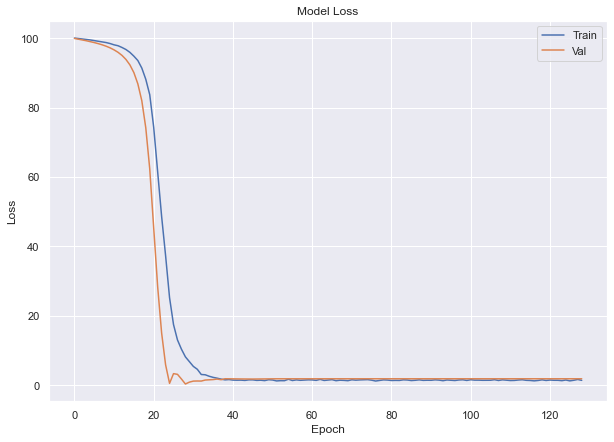

In [509]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [510]:
# remove
serie_multi1 = l_icms_ts[:-12]
print(l_icms_ts.shape)
print(serie_multi1.shape)

(240,)
(228,)


In [511]:
for i in range(12):
    # cria as séries
    X_multi1, Y_multi1 = cria_features_target(serie_multi1, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std1 = enc_x.transform(X_multi1)
    X_multi_std1 = X_multi_std1.reshape(X_multi_std1.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi1, y_multi1 = janelamento_1_mes(X_multi_std1, Y_multi1, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi1 = model.predict(x_multi1[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi1))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi1 = pd.Series(np.append(serie_multi1, y_pred_multi1))

0 [[1.6974069e+10]]
1 [[1.7100509e+10]]
2 [[1.7321667e+10]]
3 [[1.7275177e+10]]
4 [[1.7233449e+10]]
5 [[1.7226646e+10]]
6 [[1.721052e+10]]
7 [[1.7217645e+10]]
8 [[1.7202282e+10]]
9 [[1.719513e+10]]
10 [[1.7192966e+10]]
11 [[1.7188508e+10]]


In [512]:
Y_pred_multi1 = np.exp(pd.Series(serie_multi1[-12:]))
Y_pred_multi1.index = icms_ts.index[-12:]

In [513]:
RMSE_lstm_multi1 = mean_squared_error(np.exp(y_test1), Y_pred_multi1, squared=False)
RMSE_lstm_multi1

775378701.5562317

In [514]:
MAPE_lstm_multi1 = mean_absolute_percentage_error(np.exp(y_test1), Y_pred_multi1)
MAPE_lstm_multi1

0.037627493041509384

In [515]:
previsoes['nome'].append('RNN-LSTM-1-mês')
previsoes['modelo'].append(model)
previsoes['previsoes'].append(Y_pred_multi1)

previsoes['rmse'].append(RMSE_lstm_multi1)

previsoes['mape'].append(MAPE_lstm_multi1)

previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi1
                                                        , np.exp(y_test1))])

### Modelo 12 meses

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

##### Unindo novamente os dados.

In [516]:
def janelamento_12_meses(X, Y, verbose=0):
    X_exp = np.concatenate((np.roll(X, 12, axis=0),
                            np.roll(X, 11, axis=0),
                            np.roll(X, 10, axis=0),
                            np.roll(X, 9, axis=0),
                            np.roll(X, 8, axis=0),
                            np.roll(X, 7, axis=0),
                            np.roll(X, 6, axis=0),
                            np.roll(X, 5, axis=0),
                            np.roll(X, 4, axis=0),
                            np.roll(X, 3, axis=0),
                            np.roll(X, 2, axis=0),
                            np.roll(X, 1, axis=0),
                            ), axis=2)
    X_exp_cut = X_exp[12:,:,:].transpose(0,2,1)
    Y_cut = Y[12:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [517]:
X_data_exp_cut12, Y_data_cut12 = janelamento_12_meses(X_data_jn, Y_data, verbose=0)

In [518]:
#Y_data_cut[0]

In [519]:
#X_data_exp_cut[0]

In [520]:
#Y_data_cut[Y_data_cut.shape[0]-1]

In [521]:
#X_data_exp_cut[Y_data_cut.shape[0]-1]

#### Separando novamente em treino, validação e teste

In [522]:
x_train12 = X_data_exp_cut12[:-24]
x_val12 = X_data_exp_cut12[-24:-12]
x_test12 = X_data_exp_cut12[-12:]
print(x_train12.shape, x_val12.shape, x_test12.shape)
y_train12 = Y_data_cut12[:-24]
y_val12 = Y_data_cut12[-24:-12]
y_test12 = np.exp(Y_data_cut12[-12:]) # tirar o log para ficar o valor real
print(y_train12.shape, y_val12.shape, y_test12.shape)

(192, 12, 10) (12, 12, 10) (12, 12, 10)
(192,) (12,) (12,)


### Criando o modelo LSTM

In [523]:
rlrop2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stop2 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

#### Arquitetura da Rede

In [524]:
# Épocas e percentual de validação
EPOCHS2 = 700

# Imstanciação do modelo
model2 = Sequential()

# Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=0.25,
        input_shape = (12, 10), return_sequences = False,
        units = 600))

# Adicionar a camada de saída com 1 neurônio linear
model2.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model2.compile(loss = 'mape', optimizer = Adam(learning_rate=1e-5))

In [525]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 600)               1466400   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 601       
Total params: 1,467,001
Trainable params: 1,467,001
Non-trainable params: 0
_________________________________________________________________


In [526]:
# History object for plotting our model loss by epoch
history2 = model2.fit(x_train12, y_train12, batch_size = 16, 
                    epochs = EPOCHS2, validation_data = (x_val12, y_val12),
                    callbacks = [rlrop2, early_stop2])

Epoch 1/700
12/12 [==============================] - 1s 72ms/step - loss: 99.7984 - val_loss: 99.2684
Epoch 2/700
12/12 [==============================] - 1s 42ms/step - loss: 99.3055 - val_loss: 98.4822
Epoch 3/700
12/12 [==============================] - 0s 40ms/step - loss: 98.8159 - val_loss: 97.6529
Epoch 4/700
12/12 [==============================] - 1s 45ms/step - loss: 98.2346 - val_loss: 96.7633
Epoch 5/700
12/12 [==============================] - 1s 45ms/step - loss: 97.6468 - val_loss: 95.7734
Epoch 6/700
12/12 [==============================] - 0s 39ms/step - loss: 96.9895 - val_loss: 94.6258
Epoch 7/700
12/12 [==============================] - 0s 39ms/step - loss: 96.1991 - val_loss: 93.2753
Epoch 8/700
12/12 [==============================] - 0s 39ms/step - loss: 95.2915 - val_loss: 91.6200
Epoch 9/700
12/12 [==============================] - 0s 39ms/step - loss: 94.1565 - val_loss: 89.5401
Epoch 10/700
12/12 [==============================] - 0s 39ms/step - loss: 92.6759

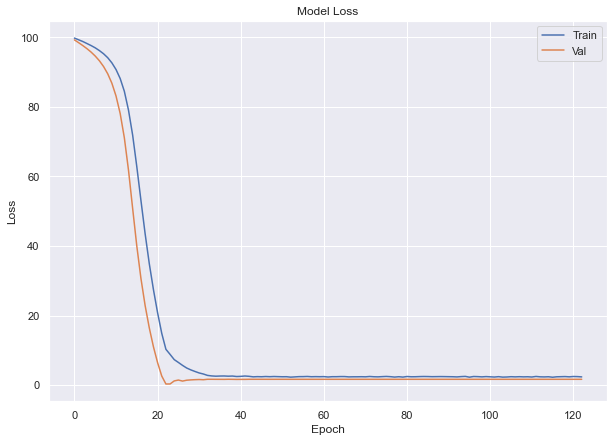

In [527]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [528]:
# remove
serie_multi12 = l_icms_ts[:-12]
print(l_icms_ts.shape)
print(serie_multi12.shape)
type(serie_multi12)

(240,)
(228,)


pandas.core.series.Series

In [529]:
for i in range(12):
    # cria as séries
    X_multi12, Y_multi12 = cria_features_target(serie_multi12, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std12 = enc_x.transform(X_multi12)
    X_multi_std12 = X_multi_std12.reshape(X_multi_std12.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi12, y_multi12 = janelamento_12_meses(X_multi_std12, Y_multi12, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi12 = model2.predict(x_multi12[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi12))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi12 = pd.Series(np.append(serie_multi12, y_pred_multi12))
    type(serie_multi12)

0 [[1.6008132e+10]]
1 [[1.6073269e+10]]
2 [[1.6093177e+10]]
3 [[1.6092627e+10]]
4 [[1.6088758e+10]]
5 [[1.6122026e+10]]
6 [[1.6199179e+10]]
7 [[1.6294779e+10]]
8 [[1.635428e+10]]
9 [[1.6430288e+10]]
10 [[1.6490976e+10]]
11 [[1.6544094e+10]]


In [530]:
Y_pred_multi12 = np.exp(pd.Series(serie_multi12[-12:])) # tira o log das previsões
Y_pred_multi12.index = l_icms_ts.index[-12:]

In [531]:
Y_pred_multi12

date
2022-01-01    1.600813e+10
2022-02-01    1.607327e+10
2022-03-01    1.609318e+10
2022-04-01    1.609263e+10
2022-05-01    1.608876e+10
2022-06-01    1.612203e+10
2022-07-01    1.619918e+10
2022-08-01    1.629478e+10
2022-09-01    1.635428e+10
2022-10-01    1.643029e+10
2022-11-01    1.649098e+10
2022-12-01    1.654409e+10
dtype: float64

In [532]:
Y_pred_multi12

date
2022-01-01    1.600813e+10
2022-02-01    1.607327e+10
2022-03-01    1.609318e+10
2022-04-01    1.609263e+10
2022-05-01    1.608876e+10
2022-06-01    1.612203e+10
2022-07-01    1.619918e+10
2022-08-01    1.629478e+10
2022-09-01    1.635428e+10
2022-10-01    1.643029e+10
2022-11-01    1.649098e+10
2022-12-01    1.654409e+10
dtype: float64

In [533]:
RMSE_lstm_multi12 = mean_squared_error(y_test12, Y_pred_multi12, squared=False)
RMSE_lstm_multi12

846602272.2954454

In [534]:
MAPE_lstm_multi12 = mean_absolute_percentage_error(y_test12, Y_pred_multi12)
MAPE_lstm_multi12

0.045839202995073776

In [535]:
previsoes['nome'].append('RNN-LSTM-12-meses')
previsoes['modelo'].append(model2)
previsoes['previsoes'].append(Y_pred_multi12)

previsoes['rmse'].append(RMSE_lstm_multi12)

previsoes['mape'].append(MAPE_lstm_multi12)

In [536]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi12
                                                        , y_test12)])

In [537]:
previsoes['nome']

['Mean',
 'SARIMA(0,1,1),(2,0,1)',
 'SARIMA(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(2,0,0)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM-1-mês',
 'RNN-LSTM-12-meses']

## Resultados

In [538]:
df_prev = pd.DataFrame(data=previsoes['previsoes'], 
                       index=previsoes['nome']).transpose()
df_prev["real"] = icms_test
df_rmse = pd.DataFrame(data=previsoes['rmse'], 
                       index=previsoes['nome']).transpose()
df_mape = pd.DataFrame(data=previsoes['mape'], 
                       index=previsoes['nome']).transpose()
df_erro = pd.DataFrame(data=previsoes['erro relativo'], 
                       index=previsoes['nome']).transpose()

In [539]:
df_prev

,Mean,"SARIMA(0,1,1),(2,0,1)","SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(2,0,0)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses,real
2022-01-01,1.546729e+10,1.748345e+10,1.790502e+10,1.750645e+10,1.762553e+10,1.763949e+10,1.762676e+10,1.800114e+10,1.697407e+10,1.600813e+10,1.675250e+10
2022-02-01,1.546729e+10,1.678663e+10,1.705301e+10,1.686397e+10,1.679506e+10,1.648776e+10,1.654143e+10,1.655124e+10,1.710051e+10,1.607327e+10,1.582980e+10
2022-03-01,1.546729e+10,1.740136e+10,1.760160e+10,1.771377e+10,1.751425e+10,1.690296e+10,1.684865e+10,1.688344e+10,1.732167e+10,1.609318e+10,1.628352e+10
2022-04-01,1.546729e+10,1.723516e+10,1.695666e+10,1.700419e+10,1.712871e+10,1.740629e+10,1.755058e+10,1.770180e+10,1.727518e+10,1.609263e+10,1.682937e+10
2022-05-01,1.546729e+10,1.727624e+10,1.655464e+10,1.729202e+10,1.727937e+10,1.727216e+10,1.743551e+10,1.772669e+10,1.723345e+10,1.608876e+10,1.689841e+10
2022-06-01,1.546729e+10,1.761164e+10,1.700425e+10,1.748070e+10,1.736553e+10,1.737543e+10,1.753977e+10,1.783509e+10,1.722664e+10,1.612203e+10,1.697456e+10
2022-07-01,1.546729e+10,1.815622e+10,1.791732e+10,1.867268e+10,1.848584e+10,1.758465e+10,1.768155e+10,1.804618e+10,1.721052e+10,1.619918e+10,1.743210e+10
2022-08-01,1.546729e+10,1.844449e+10,1.833003e+10,1.862562e+10,1.843260e+10,1.780022e+10,1.795134e+10,1.831681e+10,1.721764e+10,1.629478e+10,1.756224e+10
2022-09-01,1.546729e+10,1.888572e+10,1.874536e+10,1.905212e+10,1.887475e+10,1.836415e+10,1.851876e+10,1.894641e+10,1.720228e+10,1.635428e+10,1.726287e+10
2022-10-01,1.546729e+10,1.930925e+10,1.922765e+10,1.956299e+10,1.939979e+10,1.878566e+10,1.895572e+10,1.948064e+10,1.719513e+10,1.643029e+10,1.565000e+10


In [540]:
df_erro

,Mean,"SARIMA(0,1,1),(2,0,1)","SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(2,0,0)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses
0,7.671745,4.363216,6.879655,4.500524,5.211361,5.294685,5.218665,7.453438,1.322590,4.443332
1,2.290007,6.044495,7.727273,6.533062,6.097767,4.156491,4.495546,4.557480,8.027356,1.538071
2,5.012618,6.864825,8.094570,8.783393,7.558110,3.804045,3.470541,3.684192,6.375419,1.168942
3,8.093438,2.411243,0.756347,1.038792,1.778676,3.428094,4.285445,5.183998,2.649005,4.377710
4,8.468960,2.235854,2.034320,2.329257,2.254394,2.211740,3.178418,4.901543,1.982645,4.791299
5,8.879542,3.753188,0.174942,2.981798,2.303318,2.361607,3.329752,5.069562,1.485102,5.022389
6,11.271199,4.153938,2.783508,7.116656,6.044818,0.875096,1.430991,3.522732,1.271101,7.072699
7,11.928709,5.023548,4.371843,6.054927,4.955880,1.355051,2.215543,4.296522,1.962146,7.216974
8,10.401362,9.400865,8.587744,10.364743,9.337286,6.379483,7.275104,9.752434,0.350947,5.263233
9,1.167461,23.381806,22.860383,25.003161,23.960323,20.036150,21.122791,24.476918,9.873039,4.985863


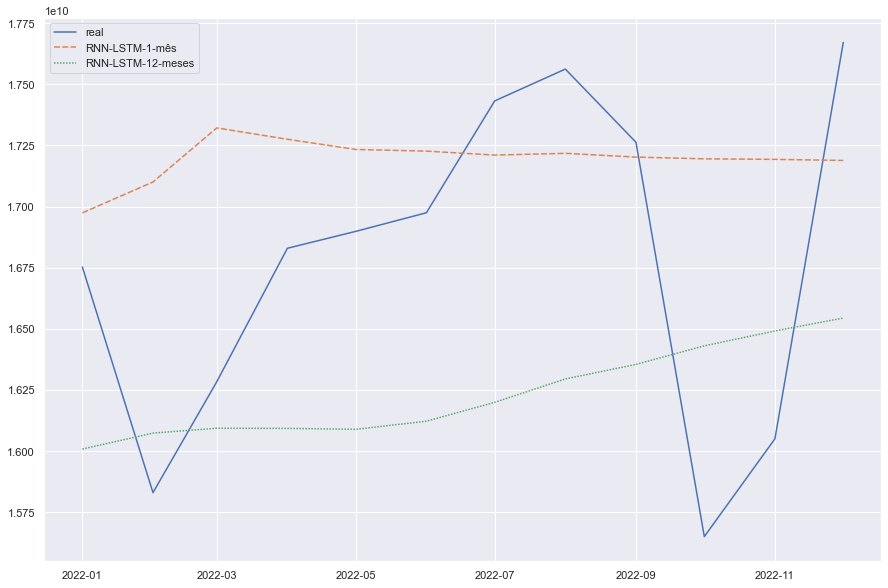

In [541]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev[['real', 'RNN-LSTM-1-mês', 'RNN-LSTM-12-meses']])

#### Previsões

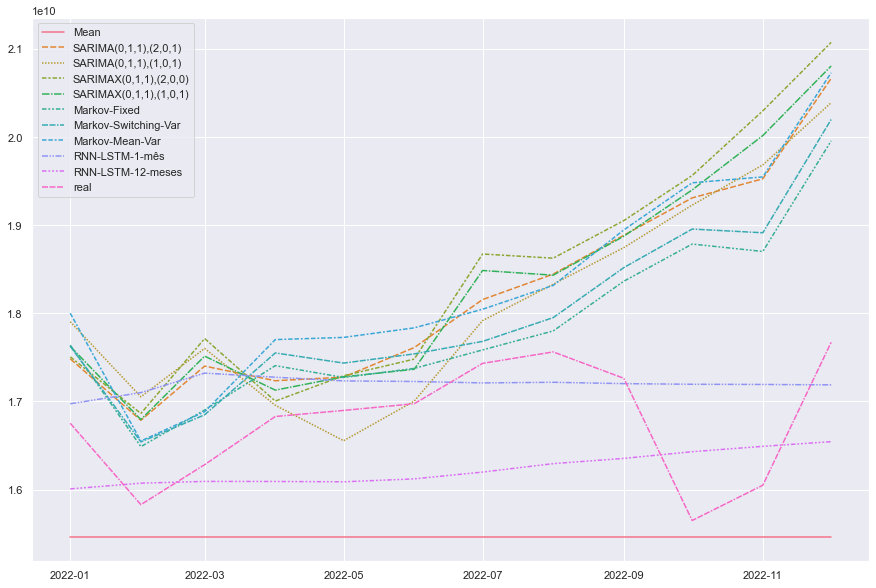

In [542]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev)

#### RMSE

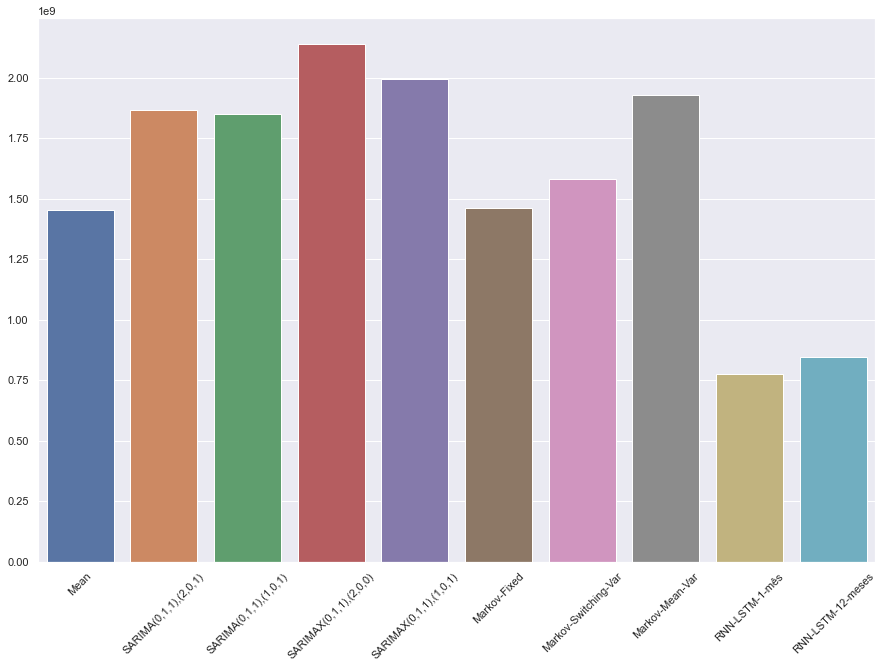

In [543]:
fig = plt.figure(figsize=(15, 10))
#df_rmse = df_rmse.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_rmse)
_ = plt.xticks(rotation=45)

#### MAPE

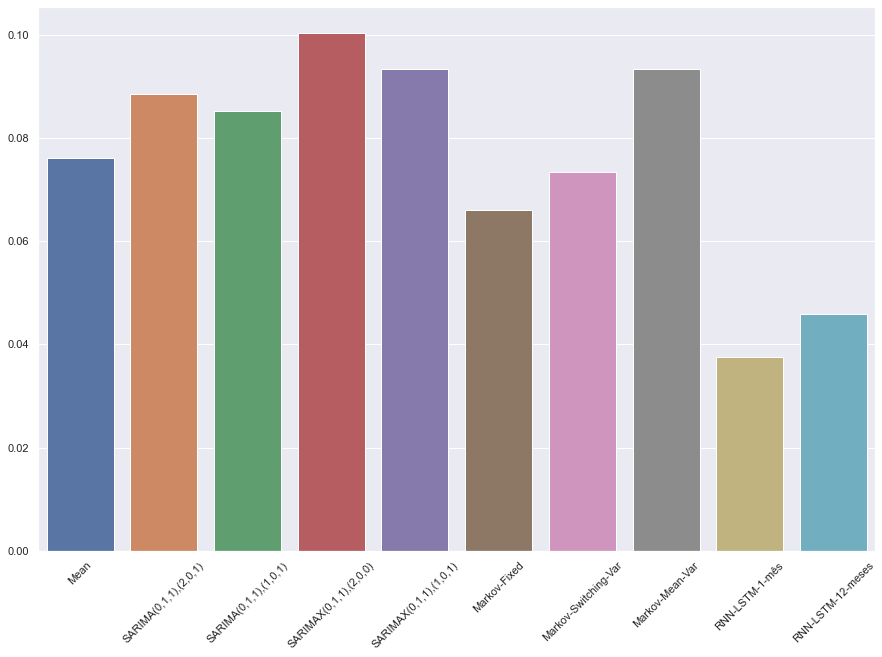

In [544]:
fig = plt.figure(figsize=(15, 10))
#df_mape = df_mape.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_mape)
_ = plt.xticks(rotation=45)

### Resumo das métricas

In [545]:
df_rmse.index = ['RMSE']
df_mape.index = ['MAPE']

In [546]:
df_metricas = df_rmse.copy()
df_metricas = df_metricas.append(df_mape.copy())
df_metricas

,Mean,"SARIMA(0,1,1),(2,0,1)","SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(2,0,0)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses
RMSE,1.452835e+09,1.866081e+09,1.850802e+09,2.139219e+09,1.993289e+09,1.460961e+09,1.581809e+09,1.929173e+09,7.753787e+08,8.466023e+08
MAPE,7.607343e-02,8.852853e-02,8.523875e-02,1.003467e-01,9.329222e-02,6.612719e-02,7.347289e-02,9.332516e-02,3.762749e-02,4.583920e-02


In [547]:
print(df_metricas.transpose().to_latex())

\begin{tabular}{lrr}
\toprule
{} &          RMSE &      MAPE \\
\midrule
Mean                   &  1.452835e+09 &  0.076073 \\
SARIMA(0,1,1),(2,0,1)  &  1.866081e+09 &  0.088529 \\
SARIMA(0,1,1),(1,0,1)  &  1.850802e+09 &  0.085239 \\
SARIMAX(0,1,1),(2,0,0) &  2.139219e+09 &  0.100347 \\
SARIMAX(0,1,1),(1,0,1) &  1.993289e+09 &  0.093292 \\
Markov-Fixed           &  1.460961e+09 &  0.066127 \\
Markov-Switching-Var   &  1.581809e+09 &  0.073473 \\
Markov-Mean-Var        &  1.929173e+09 &  0.093325 \\
RNN-LSTM-1-mês         &  7.753787e+08 &  0.037627 \\
RNN-LSTM-12-meses      &  8.466023e+08 &  0.045839 \\
\bottomrule
\end{tabular}



In [548]:
print(df_prev['2022-01-01':'2022-04-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2022-01-01 &    2022-02-01 &    2022-03-01 &    2022-04-01 \\
\midrule
Mean                   &  1.546729e+10 &  1.546729e+10 &  1.546729e+10 &  1.546729e+10 \\
SARIMA(0,1,1),(2,0,1)  &  1.748345e+10 &  1.678663e+10 &  1.740136e+10 &  1.723516e+10 \\
SARIMA(0,1,1),(1,0,1)  &  1.790502e+10 &  1.705301e+10 &  1.760160e+10 &  1.695666e+10 \\
SARIMAX(0,1,1),(2,0,0) &  1.750645e+10 &  1.686397e+10 &  1.771377e+10 &  1.700419e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.762553e+10 &  1.679506e+10 &  1.751425e+10 &  1.712871e+10 \\
Markov-Fixed           &  1.763949e+10 &  1.648776e+10 &  1.690296e+10 &  1.740629e+10 \\
Markov-Switching-Var   &  1.762676e+10 &  1.654143e+10 &  1.684865e+10 &  1.755058e+10 \\
Markov-Mean-Var        &  1.800114e+10 &  1.655124e+10 &  1.688344e+10 &  1.770180e+10 \\
RNN-LSTM-1-mês         &  1.697407e+10 &  1.710051e+10 &  1.732167e+10 &  1.727518e+10 \\
RNN-LSTM-12-meses      &  1.600813e+10 &  1.607327e+10 &  1.609318e+10 &  1.609

In [549]:
print(df_prev['2022-05-01':'2022-08-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2022-05-01 &    2022-06-01 &    2022-07-01 &    2022-08-01 \\
\midrule
Mean                   &  1.546729e+10 &  1.546729e+10 &  1.546729e+10 &  1.546729e+10 \\
SARIMA(0,1,1),(2,0,1)  &  1.727624e+10 &  1.761164e+10 &  1.815622e+10 &  1.844449e+10 \\
SARIMA(0,1,1),(1,0,1)  &  1.655464e+10 &  1.700425e+10 &  1.791732e+10 &  1.833003e+10 \\
SARIMAX(0,1,1),(2,0,0) &  1.729202e+10 &  1.748070e+10 &  1.867268e+10 &  1.862562e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.727937e+10 &  1.736553e+10 &  1.848584e+10 &  1.843260e+10 \\
Markov-Fixed           &  1.727216e+10 &  1.737543e+10 &  1.758465e+10 &  1.780022e+10 \\
Markov-Switching-Var   &  1.743551e+10 &  1.753977e+10 &  1.768155e+10 &  1.795134e+10 \\
Markov-Mean-Var        &  1.772669e+10 &  1.783509e+10 &  1.804618e+10 &  1.831681e+10 \\
RNN-LSTM-1-mês         &  1.723345e+10 &  1.722664e+10 &  1.721052e+10 &  1.721764e+10 \\
RNN-LSTM-12-meses      &  1.608876e+10 &  1.612203e+10 &  1.619918e+10 &  1.629

In [550]:
print(df_prev['2022-09-01':'2022-12-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2022-09-01 &    2022-10-01 &    2022-11-01 &    2022-12-01 \\
\midrule
Mean                   &  1.546729e+10 &  1.546729e+10 &  1.546729e+10 &  1.546729e+10 \\
SARIMA(0,1,1),(2,0,1)  &  1.888572e+10 &  1.930925e+10 &  1.952593e+10 &  2.066565e+10 \\
SARIMA(0,1,1),(1,0,1)  &  1.874536e+10 &  1.922765e+10 &  1.968328e+10 &  2.038897e+10 \\
SARIMAX(0,1,1),(2,0,0) &  1.905212e+10 &  1.956299e+10 &  2.029681e+10 &  2.107306e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.887475e+10 &  1.939979e+10 &  2.001621e+10 &  2.080574e+10 \\
Markov-Fixed           &  1.836415e+10 &  1.878566e+10 &  1.870155e+10 &  1.995620e+10 \\
Markov-Switching-Var   &  1.851876e+10 &  1.895572e+10 &  1.891368e+10 &  2.019878e+10 \\
Markov-Mean-Var        &  1.894641e+10 &  1.948064e+10 &  1.954744e+10 &  2.072858e+10 \\
RNN-LSTM-1-mês         &  1.720228e+10 &  1.719513e+10 &  1.719297e+10 &  1.718851e+10 \\
RNN-LSTM-12-meses      &  1.635428e+10 &  1.643029e+10 &  1.649098e+10 &  1.654

In [553]:
df_metricas.transpose().to_excel('./metricas_uni_2022.xlsx', index_label='modelo')

In [552]:
df_prev.to_excel('./previsoes_uni_2022.xlsx', index_label='mes_ano')